# Rossmann销售预测

**Rossmann** 是欧洲的一家连锁药店。在欧洲7个国家经营着3000多家药店。目前，Rossmann门店经理的任务是提前六 周预测他们的日常销量。商店的销售受到许多因素的影响，包括促销、竞争、学校和国家假日、季节性和所在地区。成千上万的门店经理根据其独特偏好进行销售预测，造成结果的准确性可能会偏差很大。

   可靠的销售预测使商店经理能够制定有效的员工时间表，提高生产力和积极性。通过帮助 Rossmann 创建一个健壮的预测模型，将会帮助商店经理专注于他们最重要的事情:他们的客户和他们的团队。

**数据文件：**

 - train.csv -每家店销售数据集，用于训练
 - store.csv -每家店信息数据集
 - test.csv  -跟"train.csv"结构⼀样，缺少需要提交的"Sales"字段，用于最终的测试
 - sample_submission.csv -提交数据集的参考样本
   




## 基本流程

* 1. 初始化开发环境，加载所需库。
* 2. 加载数据，数据完整性探索。（可视化图表见<a href="数据可视化.ipynb">数据可视化.ipynb</a>）
* 3. 数据预处理。
* 4. 数据探索。
* 5. 特征工程。
* 6. 模型构建、训练、调参、优化。
* 7. 生成kaggle的提交文件。
* 8. 记录kaggle得分情况。

### 环境初始化

In [1]:
# coding: utf-8
 
#开发环境：windows10, Anacoda3.5 , jupyter notebook ,python3.6 
#库： numpy,pandas,matplotlib,seaborn,xgboost,time,warnings
#运行时间：CPU: i5-6700HQ，约两个半钟
 
#项目名称： Rossmann 销售预测

#导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
from time import time
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 准备数据

所需数据都存放于当前目录的/dataset/中

部分字段解释：
1. Id:测试集内(商店、日期)的组合。
2. Store:表示每个商店的唯一Id。
3. Sales:任意一天的销售额，也是我们要预测的字段。
4. Open:是否开门，0=关门，1=开门。
5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
6. StoreType:商店类型，有四种，abcd。
7. Assortment:分类级别，a=基础，b=额外，c=扩展。
8. CompetitionDistance:竞争对手距离。
9. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
10. Promo:表示商店当天是否进行促销？
11. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
12. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
13. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

### 加载数据

In [2]:
train = pd.read_csv('./dataset/train.csv',parse_dates=[2])
test  = pd.read_csv('./dataset/test.csv',parse_dates=[3])
store = pd.read_csv('./dataset/store.csv')

### 读取数据

In [3]:
#查看训练集
train.head(5).append(train.tail())


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


总共数据 1017209 条数据，数据完整，无null字段

In [5]:
#查看测试集
test.head(5).append(test.tail())

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


"Open" 字段有11个缺失值显示为：NaN。

In [7]:
#查看店铺数据
store.head(5).append(store.tail())

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [8]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


总共有 1115 条数据，对应分布于德国的1115间商店；其中CompetitionOpenSinceMonth、CompetitionOpenSinceYear只有 761 条数据，也就是有 354 个商店缺失对应的竞争对手的开张日期相关信息；promo2促销相关的字段Promo2SinceWeek、Promo2SinceYear、PromoInterval只有 571 条；竞争对手的距离字段CompetitionDistance显示缺失值为 3 条 。

#### 时间跨度

In [9]:
print(min(train['Date']),max(train['Date']))

2013-01-01 00:00:00 2015-07-31 00:00:00


**数据集的数据从2013-01-01 到 2015-17-31 时间跨度2.5年左右**

### 缺失数据分析

In [10]:
#查看数据缺失
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [11]:
#测试集缺失数据
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [12]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

In [13]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceYear)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

In [14]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.PromoInterval)]
NoPW[NoPW.Promo2 != 0].shape


(0, 10)

#### 小结
* 1.可以看到train、test和store都有“Store”字段；
* 2.test中'open'字段有11条缺失值，需对缺失值进行处理；
* 3.store的"CompetitionDistance" "CompetitionOpenSinceMonth" "CompetitionOpenSinceYear" "Promo2SinceWeek" "Promo2SinceYear"和"PromoInterval"字段都有缺失值，同样需要对缺失值进行处理；
* 4.有大量字段属于枚举型、时间序列，这些字段都要经过处理，否则会影响预测结果。

## 数据预处理

- open统一填充为1，开放营业状态
- 店铺竞争数据缺失的原因不明，且数量比较多，我们可以用中值或者0来填充，后续的实验发现以0填充的效果更好
- 店铺促销信息的缺失是因为没有参加促销活动，所以我们以0填充


“open”字段可以填充为1 - 开放营业

In [15]:
# - open字段可以填充为1 - 开放营业
test.fillna(1, inplace=True)

CompetitionOpenSinceMonth、CompetitionOpenSinceYear、CompetitionDistance填充0

In [16]:
store.fillna(0, inplace=True)

In [17]:
test['Date'] = pd.to_datetime(test['Date'])
train['Date'] = pd.to_datetime(train['Date'])

In [18]:
#查看是否还存在缺失值
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## 数据拼接

合并store信息到train和test数据集中

In [19]:
#合并store信息到train和test数据集中
train_data = pd.merge(train, store, on='Store')
test_data = pd.merge(test, store, on='Store')

In [20]:
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [21]:
test_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## 划分数据集

留出最近的6周数据作为hold_out数据集进行测试；这样划分的基础是数据为时序数据，有助于利用时序数据的趋势特点。

In [22]:
train_data = train_data.sort_values(['Date'],ascending = False)
ho_test    = train_data[:6*7*1115]
ho_train   = train_data[6*7*1115:]
ho_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46830 entries, 0 to 284583
Data columns (total 18 columns):
Store                        46830 non-null int64
DayOfWeek                    46830 non-null int64
Date                         46830 non-null datetime64[ns]
Sales                        46830 non-null int64
Customers                    46830 non-null int64
Open                         46830 non-null int64
Promo                        46830 non-null int64
StateHoliday                 46830 non-null object
SchoolHoliday                46830 non-null int64
StoreType                    46830 non-null object
Assortment                   46830 non-null object
CompetitionDistance          46830 non-null float64
CompetitionOpenSinceMonth    46830 non-null float64
CompetitionOpenSinceYear     46830 non-null float64
Promo2                       46830 non-null int64
Promo2SinceWeek              46830 non-null float64
Promo2SinceYear              46830 non-null float64
PromoInterval     

In [23]:
#查看是否还存在缺失值
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## 清洗未开放营业和销售量为0的数据

“Sales”为0的数据不计入最终得分，因此从训练数据中去除，避免对模型的干扰。

In [24]:
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

## 特征处理和转换

#### Year、Month、Day、WeekOfYear、DayOfWeek、CompetitionOpen、PromoOpen

In [25]:
#特征处理与转化，定义特征处理函数
def features_create(data):
    
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
 
    return data

In [26]:

#对训练，保留以及测试数据集进行特征转化
features_create(ho_train)
features_create(ho_test)
features_create(test_data)
print('特征转换成功')

特征转换成功


## 数值型数据归一化处理

这主要是避免由数值大小导致的字段在对预测结果的影响中权重不一致，因此做归一化处理，即认为每个字段的影响都是一样的。

数值型字段有：
1. CompetitionDistance。
2. PromoDays。
3. CompetitionOpenMonths。

但是有个问题，如果对训练数据、测试数据分别进行了归一化，因为归一化使用的min、max不同，是否对预测有影响不可而知，暂时不进行归一化处理。

### 做归一化之前，我们要先查看下数据中是否有异常值，比如极大极小值等，避免对归一化结果造成影响

In [27]:
ho_train.CompetitionDistance.describe()

count    804056.000000
mean       5445.036515
std        7806.454956
min           0.000000
25%         700.000000
50%        2320.000000
75%        6880.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

In [28]:
#删掉训练和保留数据集中不需要的特征
ho_train.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

In [29]:
#拆分特征与标签，并将标签取对数处理
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [30]:
#删掉测试集中对应的特征与训练集保持一致
xtest =test_data.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [31]:
ho_train.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

In [32]:
ho_test.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

In [33]:
xtest.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'],
      dtype='object')

## 基准模型

基准模型采用恒定猜测为mean值的方式。

先将训练集中Sales的mean值计算出来。

In [34]:
pred_base = np.expm1(ho_ytrain).mean()
print ('基准模型预测值：'+str(pred_base))

基准模型预测值：6954.82295387386


## 性能指标

由于是要提交到kaggle，因此我们选择和kaggle一致的性能指标，即RMSPE。

In [35]:
#定义评价函数rmspe
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
 
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

#sklearn interface
def rmspe_gscv(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return rmspe(y, yhat)

rmspe_score = make_scorer(rmspe_gscv)
kfold = KFold(n_splits=5, random_state=23)

## 计算基准模型的性能

In [36]:
print ('基准模型的RMSPE：'+str(rmspe([pred_base]*len(ho_ytest), np.expm1(ho_ytest))))

基准模型的RMSPE：0.4392301338342903


### 模型构建

导入库、训练数据处理

#### 模型训练

xgboost基本调参方式：
1. 选择一个较大的学习率，一般在0.05到0.3，然后设置一个该学习率对应下合适的n_estimators。
2. 调参max_depth、min_child_weight，这两个参数对结果影响很大。
3. 调参subsample、colsample_bytree。
4. 调参gamma。
5. 降低learning_rate，再匹配一个合适的n_estimators。

由于本地硬件有限，这里只给出调参后的参数：

In [37]:
#定义评价函数rmspe
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
 
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

#sklearn interface
def rmspe_gscv(y, yhat):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return rmspe(y, yhat)

rmspe_score = make_scorer(rmspe_gscv)
kfold = KFold(n_splits=5, random_state=23)

In [38]:
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [39]:
#调试后的参数
params = {'booster': 'gbtree',
          'objective': 'reg:linear',
          "eta": 0.03,
          "max_depth": 10,
          "min_child_weight": 20,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "silent": 1,
          "gamma": 0,
          "lambda": 1,
          "alpha": 0.8,
          "random_state": 23,
          "seed": 100
         }

In [40]:
num_boost_round = 6000
#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format((end-start)))
 


Train a XGBoost model
[0]	train-rmse:8.0208	eval-rmse:8.02781	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78064	eval-rmse:7.78806	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54773	eval-rmse:7.55523	train-rmspe:0.99959	eval-rmspe:0.999596
[3]	train-rmse:7.32182	eval-rmse:7.32964	train-rmspe:0.999444	eval-rmspe:0.999451
[4]	train-rmse:7.10269	eval-rmse:7.11049	train-rmspe:0.999266	eval-rmspe:0.999276
[5]	train-rmse:6.89015	eval-rmse:6.8982	train-rmspe:0.999053	eval-rmspe:0.999066
[6]	train-rmse:6.68401	eval-rmse:6.69219	train-rmspe:0.998799	eval-rmspe:0.998815
[7]	train-rmse:6.48407	eval-rmse:6.49205	train-rmspe:0.998497	eval-rmspe:0.998516
[8]	train-rmse:6.29013	eval-rmse:6.29819	train-rmspe:0.99814	eval-rmspe:0.998165
[9]	train-rmse:6.10198	eval-rmse:6.11034	train-rmspe:0.997723	eval-rmspe:0.997754
[10]	train-rmse:

[97]	train-rmse:0.491427	eval-rmse:0.484951	train-rmspe:0.38065	eval-rmspe:0.364063
[98]	train-rmse:0.480284	eval-rmse:0.473892	train-rmspe:0.374705	eval-rmspe:0.357627
[99]	train-rmse:0.469778	eval-rmse:0.463353	train-rmspe:0.369039	eval-rmspe:0.351443
[100]	train-rmse:0.459797	eval-rmse:0.453456	train-rmspe:0.363683	eval-rmspe:0.345615
[101]	train-rmse:0.449678	eval-rmse:0.443483	train-rmspe:0.358223	eval-rmspe:0.339721
[102]	train-rmse:0.440356	eval-rmse:0.434576	train-rmspe:0.353258	eval-rmspe:0.334449
[103]	train-rmse:0.431403	eval-rmse:0.425535	train-rmspe:0.348511	eval-rmspe:0.329116
[104]	train-rmse:0.422856	eval-rmse:0.416681	train-rmspe:0.343971	eval-rmspe:0.323878
[105]	train-rmse:0.4146	eval-rmse:0.408293	train-rmspe:0.339618	eval-rmspe:0.318931
[106]	train-rmse:0.406303	eval-rmse:0.400072	train-rmspe:0.335313	eval-rmspe:0.314107
[107]	train-rmse:0.398292	eval-rmse:0.392198	train-rmspe:0.331103	eval-rmspe:0.309511
[108]	train-rmse:0.390641	eval-rmse:0.384525	train-rmspe:0.3

[193]	train-rmse:0.205686	eval-rmse:0.213618	train-rmspe:0.255154	eval-rmspe:0.226129
[194]	train-rmse:0.205493	eval-rmse:0.213525	train-rmspe:0.255217	eval-rmspe:0.226303
[195]	train-rmse:0.204314	eval-rmse:0.21247	train-rmspe:0.254467	eval-rmspe:0.225389
[196]	train-rmse:0.203175	eval-rmse:0.211443	train-rmspe:0.253463	eval-rmspe:0.224393
[197]	train-rmse:0.202494	eval-rmse:0.210853	train-rmspe:0.253082	eval-rmspe:0.223972
[198]	train-rmse:0.201374	eval-rmse:0.209817	train-rmspe:0.252271	eval-rmspe:0.222996
[199]	train-rmse:0.200901	eval-rmse:0.209441	train-rmspe:0.251759	eval-rmspe:0.222704
[200]	train-rmse:0.200429	eval-rmse:0.209007	train-rmspe:0.251262	eval-rmspe:0.222412
[201]	train-rmse:0.199669	eval-rmse:0.2084	train-rmspe:0.250781	eval-rmspe:0.221903
[202]	train-rmse:0.199394	eval-rmse:0.208219	train-rmspe:0.250714	eval-rmspe:0.221866
[203]	train-rmse:0.198687	eval-rmse:0.207536	train-rmspe:0.250239	eval-rmspe:0.221263
[204]	train-rmse:0.197919	eval-rmse:0.206912	train-rmspe:

[289]	train-rmse:0.163565	eval-rmse:0.17617	train-rmspe:0.221403	eval-rmspe:0.190776
[290]	train-rmse:0.163488	eval-rmse:0.176105	train-rmspe:0.221372	eval-rmspe:0.190705
[291]	train-rmse:0.163343	eval-rmse:0.176008	train-rmspe:0.221268	eval-rmspe:0.190584
[292]	train-rmse:0.163124	eval-rmse:0.175834	train-rmspe:0.221118	eval-rmspe:0.190412
[293]	train-rmse:0.162672	eval-rmse:0.175435	train-rmspe:0.22076	eval-rmspe:0.189977
[294]	train-rmse:0.162573	eval-rmse:0.175333	train-rmspe:0.220866	eval-rmspe:0.189891
[295]	train-rmse:0.162471	eval-rmse:0.175359	train-rmspe:0.220809	eval-rmspe:0.190028
[296]	train-rmse:0.162015	eval-rmse:0.174967	train-rmspe:0.220271	eval-rmspe:0.189587
[297]	train-rmse:0.161626	eval-rmse:0.174509	train-rmspe:0.219892	eval-rmspe:0.189124
[298]	train-rmse:0.161213	eval-rmse:0.174145	train-rmspe:0.219564	eval-rmspe:0.188718
[299]	train-rmse:0.160748	eval-rmse:0.173728	train-rmspe:0.219214	eval-rmspe:0.188289
[300]	train-rmse:0.160581	eval-rmse:0.173548	train-rmspe

[385]	train-rmse:0.140156	eval-rmse:0.156073	train-rmspe:0.200861	eval-rmspe:0.169136
[386]	train-rmse:0.139907	eval-rmse:0.155891	train-rmspe:0.200669	eval-rmspe:0.168918
[387]	train-rmse:0.139851	eval-rmse:0.155849	train-rmspe:0.200606	eval-rmspe:0.168888
[388]	train-rmse:0.139659	eval-rmse:0.155674	train-rmspe:0.200451	eval-rmspe:0.168669
[389]	train-rmse:0.139172	eval-rmse:0.155285	train-rmspe:0.200004	eval-rmspe:0.168229
[390]	train-rmse:0.138865	eval-rmse:0.155001	train-rmspe:0.19976	eval-rmspe:0.167944
[391]	train-rmse:0.138674	eval-rmse:0.154856	train-rmspe:0.199605	eval-rmspe:0.167793
[392]	train-rmse:0.13859	eval-rmse:0.154952	train-rmspe:0.199545	eval-rmspe:0.167968
[393]	train-rmse:0.138452	eval-rmse:0.154863	train-rmspe:0.199314	eval-rmspe:0.167884
[394]	train-rmse:0.138298	eval-rmse:0.154734	train-rmspe:0.199186	eval-rmspe:0.16774
[395]	train-rmse:0.138021	eval-rmse:0.154501	train-rmspe:0.198963	eval-rmspe:0.167497
[396]	train-rmse:0.137789	eval-rmse:0.15428	train-rmspe:0

[481]	train-rmse:0.126256	eval-rmse:0.145023	train-rmspe:0.188227	eval-rmspe:0.157356
[482]	train-rmse:0.126135	eval-rmse:0.14492	train-rmspe:0.188151	eval-rmspe:0.15724
[483]	train-rmse:0.126033	eval-rmse:0.144831	train-rmspe:0.188066	eval-rmspe:0.15715
[484]	train-rmse:0.125956	eval-rmse:0.144756	train-rmspe:0.188007	eval-rmspe:0.15707
[485]	train-rmse:0.125753	eval-rmse:0.144589	train-rmspe:0.187853	eval-rmspe:0.156873
[486]	train-rmse:0.125661	eval-rmse:0.144518	train-rmspe:0.187767	eval-rmspe:0.156799
[487]	train-rmse:0.125572	eval-rmse:0.144438	train-rmspe:0.187695	eval-rmspe:0.156709
[488]	train-rmse:0.125482	eval-rmse:0.14441	train-rmspe:0.187641	eval-rmspe:0.156662
[489]	train-rmse:0.12537	eval-rmse:0.144306	train-rmspe:0.18755	eval-rmspe:0.15654
[490]	train-rmse:0.12532	eval-rmse:0.144269	train-rmspe:0.187539	eval-rmspe:0.156498
[491]	train-rmse:0.125244	eval-rmse:0.144166	train-rmspe:0.187479	eval-rmspe:0.156353
[492]	train-rmse:0.125192	eval-rmse:0.144138	train-rmspe:0.1874

[577]	train-rmse:0.117787	eval-rmse:0.138185	train-rmspe:0.180238	eval-rmspe:0.149483
[578]	train-rmse:0.117726	eval-rmse:0.138153	train-rmspe:0.180199	eval-rmspe:0.149447
[579]	train-rmse:0.117644	eval-rmse:0.138106	train-rmspe:0.180131	eval-rmspe:0.14939
[580]	train-rmse:0.117611	eval-rmse:0.138039	train-rmspe:0.180107	eval-rmspe:0.14929
[581]	train-rmse:0.11758	eval-rmse:0.137979	train-rmspe:0.180038	eval-rmspe:0.14919
[582]	train-rmse:0.11755	eval-rmse:0.137957	train-rmspe:0.180012	eval-rmspe:0.149161
[583]	train-rmse:0.117476	eval-rmse:0.137911	train-rmspe:0.179949	eval-rmspe:0.149123
[584]	train-rmse:0.117412	eval-rmse:0.137859	train-rmspe:0.179898	eval-rmspe:0.149067
[585]	train-rmse:0.117355	eval-rmse:0.137778	train-rmspe:0.179867	eval-rmspe:0.148985
[586]	train-rmse:0.117302	eval-rmse:0.137729	train-rmspe:0.179824	eval-rmspe:0.148934
[587]	train-rmse:0.11728	eval-rmse:0.137713	train-rmspe:0.179674	eval-rmspe:0.148917
[588]	train-rmse:0.117221	eval-rmse:0.137657	train-rmspe:0.1

[673]	train-rmse:0.111897	eval-rmse:0.133574	train-rmspe:0.174257	eval-rmspe:0.144249
[674]	train-rmse:0.111849	eval-rmse:0.133537	train-rmspe:0.174219	eval-rmspe:0.144211
[675]	train-rmse:0.111841	eval-rmse:0.133532	train-rmspe:0.174111	eval-rmspe:0.144205
[676]	train-rmse:0.111765	eval-rmse:0.133473	train-rmspe:0.174051	eval-rmspe:0.144137
[677]	train-rmse:0.111703	eval-rmse:0.133548	train-rmspe:0.173984	eval-rmspe:0.144256
[678]	train-rmse:0.111636	eval-rmse:0.133501	train-rmspe:0.173944	eval-rmspe:0.144198
[679]	train-rmse:0.111522	eval-rmse:0.133408	train-rmspe:0.173823	eval-rmspe:0.144079
[680]	train-rmse:0.11148	eval-rmse:0.133389	train-rmspe:0.173783	eval-rmspe:0.144058
[681]	train-rmse:0.11146	eval-rmse:0.133375	train-rmspe:0.173768	eval-rmspe:0.144046
[682]	train-rmse:0.111411	eval-rmse:0.133333	train-rmspe:0.173718	eval-rmspe:0.144
[683]	train-rmse:0.111336	eval-rmse:0.133278	train-rmspe:0.17367	eval-rmspe:0.143943
[684]	train-rmse:0.111287	eval-rmse:0.133239	train-rmspe:0.1

[769]	train-rmse:0.107206	eval-rmse:0.13039	train-rmspe:0.169631	eval-rmspe:0.140817
[770]	train-rmse:0.107178	eval-rmse:0.130382	train-rmspe:0.16964	eval-rmspe:0.140798
[771]	train-rmse:0.107164	eval-rmse:0.130392	train-rmspe:0.169628	eval-rmspe:0.14082
[772]	train-rmse:0.107086	eval-rmse:0.130335	train-rmspe:0.169578	eval-rmspe:0.140752
[773]	train-rmse:0.107036	eval-rmse:0.130301	train-rmspe:0.169556	eval-rmspe:0.140706
[774]	train-rmse:0.106982	eval-rmse:0.130258	train-rmspe:0.169516	eval-rmspe:0.140673
[775]	train-rmse:0.106928	eval-rmse:0.130209	train-rmspe:0.169476	eval-rmspe:0.140614
[776]	train-rmse:0.106866	eval-rmse:0.130161	train-rmspe:0.169424	eval-rmspe:0.140563
[777]	train-rmse:0.106851	eval-rmse:0.130164	train-rmspe:0.169413	eval-rmspe:0.140567
[778]	train-rmse:0.1068	eval-rmse:0.130272	train-rmspe:0.169348	eval-rmspe:0.140691
[779]	train-rmse:0.10674	eval-rmse:0.130223	train-rmspe:0.169306	eval-rmspe:0.140636
[780]	train-rmse:0.106692	eval-rmse:0.130192	train-rmspe:0.1

[865]	train-rmse:0.103435	eval-rmse:0.127992	train-rmspe:0.165307	eval-rmspe:0.138139
[866]	train-rmse:0.103397	eval-rmse:0.127966	train-rmspe:0.165281	eval-rmspe:0.138112
[867]	train-rmse:0.10332	eval-rmse:0.127906	train-rmspe:0.165224	eval-rmspe:0.138052
[868]	train-rmse:0.103237	eval-rmse:0.127843	train-rmspe:0.165146	eval-rmspe:0.137964
[869]	train-rmse:0.10322	eval-rmse:0.127834	train-rmspe:0.165011	eval-rmspe:0.137955
[870]	train-rmse:0.103155	eval-rmse:0.127782	train-rmspe:0.16496	eval-rmspe:0.137901
[871]	train-rmse:0.103135	eval-rmse:0.127771	train-rmspe:0.164945	eval-rmspe:0.137888
[872]	train-rmse:0.103091	eval-rmse:0.127834	train-rmspe:0.164915	eval-rmspe:0.137962
[873]	train-rmse:0.103033	eval-rmse:0.127822	train-rmspe:0.16481	eval-rmspe:0.137954
[874]	train-rmse:0.103011	eval-rmse:0.127806	train-rmspe:0.164784	eval-rmspe:0.137937
[875]	train-rmse:0.102947	eval-rmse:0.127764	train-rmspe:0.164738	eval-rmspe:0.137885
[876]	train-rmse:0.102923	eval-rmse:0.127746	train-rmspe:0

[961]	train-rmse:0.100302	eval-rmse:0.126085	train-rmspe:0.161793	eval-rmspe:0.135994
[962]	train-rmse:0.100283	eval-rmse:0.12607	train-rmspe:0.16178	eval-rmspe:0.135977
[963]	train-rmse:0.100256	eval-rmse:0.126051	train-rmspe:0.161743	eval-rmspe:0.135954
[964]	train-rmse:0.10025	eval-rmse:0.126048	train-rmspe:0.161739	eval-rmspe:0.135952
[965]	train-rmse:0.100218	eval-rmse:0.126026	train-rmspe:0.161715	eval-rmspe:0.135924
[966]	train-rmse:0.100184	eval-rmse:0.126002	train-rmspe:0.16171	eval-rmspe:0.135896
[967]	train-rmse:0.100145	eval-rmse:0.125978	train-rmspe:0.161683	eval-rmspe:0.135871
[968]	train-rmse:0.100129	eval-rmse:0.125972	train-rmspe:0.161673	eval-rmspe:0.135873
[969]	train-rmse:0.100103	eval-rmse:0.125956	train-rmspe:0.161652	eval-rmspe:0.135856
[970]	train-rmse:0.100037	eval-rmse:0.125904	train-rmspe:0.161608	eval-rmspe:0.135797
[971]	train-rmse:0.10002	eval-rmse:0.125897	train-rmspe:0.161595	eval-rmspe:0.135789
[972]	train-rmse:0.1	eval-rmse:0.125891	train-rmspe:0.16157

[1057]	train-rmse:0.097714	eval-rmse:0.12449	train-rmspe:0.158293	eval-rmspe:0.134204
[1058]	train-rmse:0.097698	eval-rmse:0.124504	train-rmspe:0.158279	eval-rmspe:0.13423
[1059]	train-rmse:0.097681	eval-rmse:0.124502	train-rmspe:0.158253	eval-rmspe:0.134228
[1060]	train-rmse:0.097656	eval-rmse:0.124488	train-rmspe:0.158227	eval-rmspe:0.13421
[1061]	train-rmse:0.097631	eval-rmse:0.124433	train-rmspe:0.158185	eval-rmspe:0.134127
[1062]	train-rmse:0.097613	eval-rmse:0.124423	train-rmspe:0.158172	eval-rmspe:0.134116
[1063]	train-rmse:0.097601	eval-rmse:0.124405	train-rmspe:0.15817	eval-rmspe:0.134103
[1064]	train-rmse:0.097577	eval-rmse:0.124389	train-rmspe:0.158163	eval-rmspe:0.134086
[1065]	train-rmse:0.097541	eval-rmse:0.124369	train-rmspe:0.15822	eval-rmspe:0.13406
[1066]	train-rmse:0.097515	eval-rmse:0.124352	train-rmspe:0.158199	eval-rmspe:0.13404
[1067]	train-rmse:0.097494	eval-rmse:0.124337	train-rmspe:0.158169	eval-rmspe:0.134023
[1068]	train-rmse:0.09747	eval-rmse:0.124319	train

[1152]	train-rmse:0.095689	eval-rmse:0.123447	train-rmspe:0.155348	eval-rmspe:0.133061
[1153]	train-rmse:0.095664	eval-rmse:0.123428	train-rmspe:0.155326	eval-rmspe:0.133042
[1154]	train-rmse:0.095646	eval-rmse:0.123416	train-rmspe:0.155314	eval-rmspe:0.133028
[1155]	train-rmse:0.095604	eval-rmse:0.123403	train-rmspe:0.15525	eval-rmspe:0.133014
[1156]	train-rmse:0.095591	eval-rmse:0.123395	train-rmspe:0.155225	eval-rmspe:0.133007
[1157]	train-rmse:0.095583	eval-rmse:0.123394	train-rmspe:0.155215	eval-rmspe:0.133005
[1158]	train-rmse:0.095559	eval-rmse:0.123379	train-rmspe:0.155264	eval-rmspe:0.132993
[1159]	train-rmse:0.095541	eval-rmse:0.123394	train-rmspe:0.15523	eval-rmspe:0.133007
[1160]	train-rmse:0.095533	eval-rmse:0.123398	train-rmspe:0.155225	eval-rmspe:0.133015
[1161]	train-rmse:0.095516	eval-rmse:0.123376	train-rmspe:0.155188	eval-rmspe:0.132994
[1162]	train-rmse:0.095502	eval-rmse:0.123366	train-rmspe:0.155183	eval-rmspe:0.132983
[1163]	train-rmse:0.095485	eval-rmse:0.123355

[1247]	train-rmse:0.093823	eval-rmse:0.12266	train-rmspe:0.152415	eval-rmspe:0.132128
[1248]	train-rmse:0.093816	eval-rmse:0.122664	train-rmspe:0.152412	eval-rmspe:0.132135
[1249]	train-rmse:0.093785	eval-rmse:0.122642	train-rmspe:0.152396	eval-rmspe:0.132111
[1250]	train-rmse:0.093774	eval-rmse:0.122665	train-rmspe:0.152386	eval-rmspe:0.132146
[1251]	train-rmse:0.093753	eval-rmse:0.122652	train-rmspe:0.152371	eval-rmspe:0.13213
[1252]	train-rmse:0.093732	eval-rmse:0.122633	train-rmspe:0.152273	eval-rmspe:0.132105
[1253]	train-rmse:0.093709	eval-rmse:0.122606	train-rmspe:0.152259	eval-rmspe:0.132074
[1254]	train-rmse:0.093698	eval-rmse:0.122602	train-rmspe:0.152242	eval-rmspe:0.132069
[1255]	train-rmse:0.093691	eval-rmse:0.122602	train-rmspe:0.152239	eval-rmspe:0.13207
[1256]	train-rmse:0.09368	eval-rmse:0.122601	train-rmspe:0.152231	eval-rmspe:0.132072
[1257]	train-rmse:0.093666	eval-rmse:0.122596	train-rmspe:0.152214	eval-rmspe:0.132067
[1258]	train-rmse:0.093654	eval-rmse:0.122588	t

[1342]	train-rmse:0.092323	eval-rmse:0.122043	train-rmspe:0.14992	eval-rmspe:0.131482
[1343]	train-rmse:0.092301	eval-rmse:0.122032	train-rmspe:0.149896	eval-rmspe:0.13147
[1344]	train-rmse:0.09228	eval-rmse:0.122022	train-rmspe:0.149881	eval-rmspe:0.131461
[1345]	train-rmse:0.092265	eval-rmse:0.122017	train-rmspe:0.149866	eval-rmspe:0.131457
[1346]	train-rmse:0.092254	eval-rmse:0.122018	train-rmspe:0.149817	eval-rmspe:0.131458
[1347]	train-rmse:0.092246	eval-rmse:0.122013	train-rmspe:0.149806	eval-rmspe:0.131453
[1348]	train-rmse:0.092209	eval-rmse:0.121988	train-rmspe:0.149778	eval-rmspe:0.131427
[1349]	train-rmse:0.092198	eval-rmse:0.121987	train-rmspe:0.149756	eval-rmspe:0.131427
[1350]	train-rmse:0.092185	eval-rmse:0.121979	train-rmspe:0.149747	eval-rmspe:0.131417
[1351]	train-rmse:0.092177	eval-rmse:0.121979	train-rmspe:0.149662	eval-rmspe:0.131416
[1352]	train-rmse:0.092167	eval-rmse:0.121975	train-rmspe:0.14963	eval-rmspe:0.131407
[1353]	train-rmse:0.092158	eval-rmse:0.121964	t

[1437]	train-rmse:0.0909	eval-rmse:0.121373	train-rmspe:0.146745	eval-rmspe:0.130699
[1438]	train-rmse:0.090887	eval-rmse:0.121365	train-rmspe:0.146735	eval-rmspe:0.13069
[1439]	train-rmse:0.090873	eval-rmse:0.121366	train-rmspe:0.146725	eval-rmspe:0.130686
[1440]	train-rmse:0.09086	eval-rmse:0.121389	train-rmspe:0.146699	eval-rmspe:0.130709
[1441]	train-rmse:0.090845	eval-rmse:0.121383	train-rmspe:0.146686	eval-rmspe:0.130705
[1442]	train-rmse:0.090833	eval-rmse:0.121388	train-rmspe:0.14668	eval-rmspe:0.130712
[1443]	train-rmse:0.090824	eval-rmse:0.121382	train-rmspe:0.146674	eval-rmspe:0.130706
[1444]	train-rmse:0.090812	eval-rmse:0.121375	train-rmspe:0.146656	eval-rmspe:0.130699
[1445]	train-rmse:0.090794	eval-rmse:0.121362	train-rmspe:0.146645	eval-rmspe:0.130684
[1446]	train-rmse:0.090773	eval-rmse:0.121351	train-rmspe:0.146634	eval-rmspe:0.130674
[1447]	train-rmse:0.090759	eval-rmse:0.121344	train-rmspe:0.146611	eval-rmspe:0.130666
[1448]	train-rmse:0.090751	eval-rmse:0.121346	tr

[1532]	train-rmse:0.089777	eval-rmse:0.120934	train-rmspe:0.144161	eval-rmspe:0.130257
[1533]	train-rmse:0.089768	eval-rmse:0.120932	train-rmspe:0.144154	eval-rmspe:0.130257
[1534]	train-rmse:0.089743	eval-rmse:0.12092	train-rmspe:0.144135	eval-rmspe:0.130242
[1535]	train-rmse:0.089731	eval-rmse:0.120912	train-rmspe:0.144125	eval-rmspe:0.130235
[1536]	train-rmse:0.089718	eval-rmse:0.120909	train-rmspe:0.144115	eval-rmspe:0.130233
[1537]	train-rmse:0.089713	eval-rmse:0.120906	train-rmspe:0.144111	eval-rmspe:0.130231
[1538]	train-rmse:0.089703	eval-rmse:0.120904	train-rmspe:0.144097	eval-rmspe:0.130229
[1539]	train-rmse:0.089691	eval-rmse:0.120899	train-rmspe:0.14409	eval-rmspe:0.130224
[1540]	train-rmse:0.089677	eval-rmse:0.120895	train-rmspe:0.14408	eval-rmspe:0.13022
[1541]	train-rmse:0.089668	eval-rmse:0.120896	train-rmspe:0.144067	eval-rmspe:0.130221
[1542]	train-rmse:0.089653	eval-rmse:0.120933	train-rmspe:0.143977	eval-rmspe:0.130276
[1543]	train-rmse:0.089644	eval-rmse:0.120926	t

[1627]	train-rmse:0.0887	eval-rmse:0.120501	train-rmspe:0.142068	eval-rmspe:0.129802
[1628]	train-rmse:0.088684	eval-rmse:0.120489	train-rmspe:0.142054	eval-rmspe:0.129765
[1629]	train-rmse:0.088669	eval-rmse:0.120481	train-rmspe:0.14204	eval-rmspe:0.129754
[1630]	train-rmse:0.088653	eval-rmse:0.120471	train-rmspe:0.142015	eval-rmspe:0.129743
[1631]	train-rmse:0.088647	eval-rmse:0.120469	train-rmspe:0.141949	eval-rmspe:0.129743
[1632]	train-rmse:0.088633	eval-rmse:0.120465	train-rmspe:0.141936	eval-rmspe:0.129739
[1633]	train-rmse:0.088616	eval-rmse:0.120457	train-rmspe:0.141859	eval-rmspe:0.12973
[1634]	train-rmse:0.088606	eval-rmse:0.120451	train-rmspe:0.141848	eval-rmspe:0.129726
[1635]	train-rmse:0.088594	eval-rmse:0.120445	train-rmspe:0.141822	eval-rmspe:0.129717
[1636]	train-rmse:0.088582	eval-rmse:0.120439	train-rmspe:0.141809	eval-rmspe:0.129708
[1637]	train-rmse:0.088575	eval-rmse:0.120435	train-rmspe:0.141802	eval-rmspe:0.129706
[1638]	train-rmse:0.088567	eval-rmse:0.120428	t

[1722]	train-rmse:0.087665	eval-rmse:0.120052	train-rmspe:0.138327	eval-rmspe:0.129285
[1723]	train-rmse:0.087651	eval-rmse:0.120047	train-rmspe:0.138247	eval-rmspe:0.129281
[1724]	train-rmse:0.087643	eval-rmse:0.120045	train-rmspe:0.138241	eval-rmspe:0.12928
[1725]	train-rmse:0.08763	eval-rmse:0.120055	train-rmspe:0.138229	eval-rmspe:0.129297
[1726]	train-rmse:0.087626	eval-rmse:0.120053	train-rmspe:0.138234	eval-rmspe:0.129295
[1727]	train-rmse:0.087617	eval-rmse:0.120063	train-rmspe:0.138223	eval-rmspe:0.129308
[1728]	train-rmse:0.087604	eval-rmse:0.120056	train-rmspe:0.138204	eval-rmspe:0.129304
[1729]	train-rmse:0.087593	eval-rmse:0.120051	train-rmspe:0.138195	eval-rmspe:0.129302
[1730]	train-rmse:0.087588	eval-rmse:0.120048	train-rmspe:0.138173	eval-rmspe:0.1293
[1731]	train-rmse:0.08758	eval-rmse:0.120042	train-rmspe:0.138154	eval-rmspe:0.129294
[1732]	train-rmse:0.087561	eval-rmse:0.120032	train-rmspe:0.13814	eval-rmspe:0.129283
[1733]	train-rmse:0.087557	eval-rmse:0.120026	tra

[1817]	train-rmse:0.086715	eval-rmse:0.119805	train-rmspe:0.135913	eval-rmspe:0.129078
[1818]	train-rmse:0.086701	eval-rmse:0.119798	train-rmspe:0.135898	eval-rmspe:0.129071
[1819]	train-rmse:0.086694	eval-rmse:0.119799	train-rmspe:0.135888	eval-rmspe:0.129073
[1820]	train-rmse:0.086682	eval-rmse:0.119806	train-rmspe:0.135687	eval-rmspe:0.129079
[1821]	train-rmse:0.086665	eval-rmse:0.119798	train-rmspe:0.135674	eval-rmspe:0.129071
[1822]	train-rmse:0.086655	eval-rmse:0.119804	train-rmspe:0.135665	eval-rmspe:0.129083
[1823]	train-rmse:0.086646	eval-rmse:0.119804	train-rmspe:0.135649	eval-rmspe:0.129083
[1824]	train-rmse:0.086636	eval-rmse:0.119802	train-rmspe:0.135604	eval-rmspe:0.129082
[1825]	train-rmse:0.086622	eval-rmse:0.119791	train-rmspe:0.135595	eval-rmspe:0.129069
[1826]	train-rmse:0.086606	eval-rmse:0.119789	train-rmspe:0.135578	eval-rmspe:0.129068
[1827]	train-rmse:0.086599	eval-rmse:0.119786	train-rmspe:0.135363	eval-rmspe:0.129066
[1828]	train-rmse:0.086585	eval-rmse:0.1197

[1912]	train-rmse:0.085869	eval-rmse:0.119563	train-rmspe:0.132887	eval-rmspe:0.128819
[1913]	train-rmse:0.085854	eval-rmse:0.119562	train-rmspe:0.13279	eval-rmspe:0.128822
[1914]	train-rmse:0.085843	eval-rmse:0.119557	train-rmspe:0.132777	eval-rmspe:0.128815
[1915]	train-rmse:0.08583	eval-rmse:0.119542	train-rmspe:0.132726	eval-rmspe:0.1288
[1916]	train-rmse:0.085823	eval-rmse:0.119536	train-rmspe:0.132721	eval-rmspe:0.128788
[1917]	train-rmse:0.085816	eval-rmse:0.119535	train-rmspe:0.132665	eval-rmspe:0.128787
[1918]	train-rmse:0.08581	eval-rmse:0.119533	train-rmspe:0.132656	eval-rmspe:0.128785
[1919]	train-rmse:0.085801	eval-rmse:0.119528	train-rmspe:0.13261	eval-rmspe:0.12878
[1920]	train-rmse:0.085793	eval-rmse:0.119523	train-rmspe:0.132606	eval-rmspe:0.128771
[1921]	train-rmse:0.085786	eval-rmse:0.119523	train-rmspe:0.132591	eval-rmspe:0.128772
[1922]	train-rmse:0.085779	eval-rmse:0.119521	train-rmspe:0.132583	eval-rmspe:0.12877
[1923]	train-rmse:0.085763	eval-rmse:0.119517	train

[2007]	train-rmse:0.085058	eval-rmse:0.119227	train-rmspe:0.130965	eval-rmspe:0.128453
[2008]	train-rmse:0.085051	eval-rmse:0.119227	train-rmspe:0.130958	eval-rmspe:0.128452
[2009]	train-rmse:0.085044	eval-rmse:0.119229	train-rmspe:0.130951	eval-rmspe:0.128455
[2010]	train-rmse:0.085038	eval-rmse:0.119231	train-rmspe:0.130946	eval-rmspe:0.128456
[2011]	train-rmse:0.085027	eval-rmse:0.119221	train-rmspe:0.130891	eval-rmspe:0.128445
[2012]	train-rmse:0.085019	eval-rmse:0.119219	train-rmspe:0.130882	eval-rmspe:0.128443
[2013]	train-rmse:0.08501	eval-rmse:0.119212	train-rmspe:0.130872	eval-rmspe:0.128432
[2014]	train-rmse:0.084998	eval-rmse:0.119208	train-rmspe:0.13086	eval-rmspe:0.128426
[2015]	train-rmse:0.084993	eval-rmse:0.119207	train-rmspe:0.13085	eval-rmspe:0.128426
[2016]	train-rmse:0.084987	eval-rmse:0.119203	train-rmspe:0.130786	eval-rmspe:0.128422
[2017]	train-rmse:0.084979	eval-rmse:0.119197	train-rmspe:0.130779	eval-rmspe:0.128416
[2018]	train-rmse:0.084974	eval-rmse:0.119194	

[2102]	train-rmse:0.084295	eval-rmse:0.118974	train-rmspe:0.128805	eval-rmspe:0.128173
[2103]	train-rmse:0.084289	eval-rmse:0.118974	train-rmspe:0.128654	eval-rmspe:0.128172
[2104]	train-rmse:0.08428	eval-rmse:0.118966	train-rmspe:0.128651	eval-rmspe:0.128164
[2105]	train-rmse:0.084266	eval-rmse:0.11899	train-rmspe:0.128647	eval-rmspe:0.128189
[2106]	train-rmse:0.08426	eval-rmse:0.118988	train-rmspe:0.12864	eval-rmspe:0.128188
[2107]	train-rmse:0.084251	eval-rmse:0.118992	train-rmspe:0.128634	eval-rmspe:0.128193
[2108]	train-rmse:0.084244	eval-rmse:0.118985	train-rmspe:0.12862	eval-rmspe:0.128186
[2109]	train-rmse:0.084234	eval-rmse:0.118984	train-rmspe:0.128612	eval-rmspe:0.128182
[2110]	train-rmse:0.084228	eval-rmse:0.11898	train-rmspe:0.128607	eval-rmspe:0.128176
[2111]	train-rmse:0.084219	eval-rmse:0.118981	train-rmspe:0.128595	eval-rmspe:0.128178
[2112]	train-rmse:0.084215	eval-rmse:0.118978	train-rmspe:0.128552	eval-rmspe:0.128175
[2113]	train-rmse:0.084203	eval-rmse:0.118977	tra

[2197]	train-rmse:0.083644	eval-rmse:0.11879	train-rmspe:0.126605	eval-rmspe:0.127988
[2198]	train-rmse:0.083639	eval-rmse:0.11879	train-rmspe:0.126491	eval-rmspe:0.127988
[2199]	train-rmse:0.083634	eval-rmse:0.118788	train-rmspe:0.126487	eval-rmspe:0.12799
[2200]	train-rmse:0.083626	eval-rmse:0.118786	train-rmspe:0.126472	eval-rmspe:0.127986
[2201]	train-rmse:0.08362	eval-rmse:0.118785	train-rmspe:0.126478	eval-rmspe:0.127984
[2202]	train-rmse:0.083613	eval-rmse:0.118785	train-rmspe:0.126469	eval-rmspe:0.127984
[2203]	train-rmse:0.083607	eval-rmse:0.118786	train-rmspe:0.126464	eval-rmspe:0.127986
[2204]	train-rmse:0.083603	eval-rmse:0.118783	train-rmspe:0.12646	eval-rmspe:0.127981
[2205]	train-rmse:0.083591	eval-rmse:0.118776	train-rmspe:0.12645	eval-rmspe:0.127972
[2206]	train-rmse:0.083584	eval-rmse:0.118773	train-rmspe:0.1263	eval-rmspe:0.12797
[2207]	train-rmse:0.083575	eval-rmse:0.11877	train-rmspe:0.126255	eval-rmspe:0.127968
[2208]	train-rmse:0.083565	eval-rmse:0.118767	train-r

[2292]	train-rmse:0.083006	eval-rmse:0.118633	train-rmspe:0.12489	eval-rmspe:0.127832
[2293]	train-rmse:0.083002	eval-rmse:0.118624	train-rmspe:0.12477	eval-rmspe:0.127812
[2294]	train-rmse:0.082997	eval-rmse:0.118621	train-rmspe:0.124752	eval-rmspe:0.127809
[2295]	train-rmse:0.08299	eval-rmse:0.118619	train-rmspe:0.124673	eval-rmspe:0.127808
[2296]	train-rmse:0.082984	eval-rmse:0.118618	train-rmspe:0.124661	eval-rmspe:0.127805
[2297]	train-rmse:0.08298	eval-rmse:0.118614	train-rmspe:0.12466	eval-rmspe:0.127802
[2298]	train-rmse:0.082973	eval-rmse:0.118607	train-rmspe:0.124644	eval-rmspe:0.127793
[2299]	train-rmse:0.082967	eval-rmse:0.118606	train-rmspe:0.124634	eval-rmspe:0.127794
[2300]	train-rmse:0.082961	eval-rmse:0.118605	train-rmspe:0.124618	eval-rmspe:0.127794
[2301]	train-rmse:0.082955	eval-rmse:0.118606	train-rmspe:0.124612	eval-rmspe:0.127793
[2302]	train-rmse:0.082947	eval-rmse:0.118606	train-rmspe:0.12446	eval-rmspe:0.12779
[2303]	train-rmse:0.082939	eval-rmse:0.118602	trai

[2387]	train-rmse:0.082386	eval-rmse:0.118452	train-rmspe:0.121929	eval-rmspe:0.127605
[2388]	train-rmse:0.082382	eval-rmse:0.118451	train-rmspe:0.121924	eval-rmspe:0.127604
[2389]	train-rmse:0.082378	eval-rmse:0.118451	train-rmspe:0.12193	eval-rmspe:0.127606
[2390]	train-rmse:0.082373	eval-rmse:0.11845	train-rmspe:0.121925	eval-rmspe:0.127604
[2391]	train-rmse:0.082367	eval-rmse:0.118447	train-rmspe:0.12192	eval-rmspe:0.127599
[2392]	train-rmse:0.082363	eval-rmse:0.118448	train-rmspe:0.121917	eval-rmspe:0.127601
[2393]	train-rmse:0.082358	eval-rmse:0.118447	train-rmspe:0.121905	eval-rmspe:0.1276
[2394]	train-rmse:0.082352	eval-rmse:0.118443	train-rmspe:0.121868	eval-rmspe:0.127601
[2395]	train-rmse:0.082349	eval-rmse:0.118442	train-rmspe:0.121839	eval-rmspe:0.127599
[2396]	train-rmse:0.082342	eval-rmse:0.118439	train-rmspe:0.12181	eval-rmspe:0.127596
[2397]	train-rmse:0.082333	eval-rmse:0.118455	train-rmspe:0.121659	eval-rmspe:0.127611
[2398]	train-rmse:0.082326	eval-rmse:0.118454	tra

[2482]	train-rmse:0.081794	eval-rmse:0.118237	train-rmspe:0.120011	eval-rmspe:0.127363
[2483]	train-rmse:0.081791	eval-rmse:0.118238	train-rmspe:0.119987	eval-rmspe:0.127365
[2484]	train-rmse:0.081775	eval-rmse:0.118229	train-rmspe:0.11997	eval-rmspe:0.127356
[2485]	train-rmse:0.081769	eval-rmse:0.118228	train-rmspe:0.119966	eval-rmspe:0.127356
[2486]	train-rmse:0.081762	eval-rmse:0.118226	train-rmspe:0.119956	eval-rmspe:0.127353
[2487]	train-rmse:0.081757	eval-rmse:0.118222	train-rmspe:0.119948	eval-rmspe:0.127348
[2488]	train-rmse:0.081749	eval-rmse:0.118216	train-rmspe:0.119795	eval-rmspe:0.127341
[2489]	train-rmse:0.081743	eval-rmse:0.118202	train-rmspe:0.11979	eval-rmspe:0.127321
[2490]	train-rmse:0.081737	eval-rmse:0.118202	train-rmspe:0.119786	eval-rmspe:0.127321
[2491]	train-rmse:0.081733	eval-rmse:0.118202	train-rmspe:0.11978	eval-rmspe:0.127323
[2492]	train-rmse:0.081727	eval-rmse:0.118198	train-rmspe:0.119662	eval-rmspe:0.127317
[2493]	train-rmse:0.081724	eval-rmse:0.118198	

[2577]	train-rmse:0.081224	eval-rmse:0.118042	train-rmspe:0.117431	eval-rmspe:0.127136
[2578]	train-rmse:0.081214	eval-rmse:0.118036	train-rmspe:0.117412	eval-rmspe:0.127129
[2579]	train-rmse:0.081208	eval-rmse:0.118033	train-rmspe:0.117405	eval-rmspe:0.127126
[2580]	train-rmse:0.081204	eval-rmse:0.118033	train-rmspe:0.117394	eval-rmspe:0.127129
[2581]	train-rmse:0.081199	eval-rmse:0.118031	train-rmspe:0.117391	eval-rmspe:0.127125
[2582]	train-rmse:0.081195	eval-rmse:0.11803	train-rmspe:0.117387	eval-rmspe:0.127125
[2583]	train-rmse:0.08119	eval-rmse:0.118031	train-rmspe:0.117383	eval-rmspe:0.127125
[2584]	train-rmse:0.081184	eval-rmse:0.118029	train-rmspe:0.11738	eval-rmspe:0.127123
[2585]	train-rmse:0.081178	eval-rmse:0.118025	train-rmspe:0.117364	eval-rmspe:0.127117
[2586]	train-rmse:0.081173	eval-rmse:0.118024	train-rmspe:0.117357	eval-rmspe:0.127115
[2587]	train-rmse:0.081169	eval-rmse:0.118021	train-rmspe:0.117352	eval-rmspe:0.127113
[2588]	train-rmse:0.08116	eval-rmse:0.118017	t

[2672]	train-rmse:0.080718	eval-rmse:0.11793	train-rmspe:0.116238	eval-rmspe:0.127031
[2673]	train-rmse:0.080714	eval-rmse:0.11793	train-rmspe:0.116232	eval-rmspe:0.12703
[2674]	train-rmse:0.080709	eval-rmse:0.117928	train-rmspe:0.116225	eval-rmspe:0.127028
[2675]	train-rmse:0.080701	eval-rmse:0.11793	train-rmspe:0.116212	eval-rmspe:0.127032
[2676]	train-rmse:0.080697	eval-rmse:0.117927	train-rmspe:0.116151	eval-rmspe:0.127028
[2677]	train-rmse:0.080693	eval-rmse:0.117927	train-rmspe:0.116124	eval-rmspe:0.127028
[2678]	train-rmse:0.080689	eval-rmse:0.117931	train-rmspe:0.116085	eval-rmspe:0.127032
[2679]	train-rmse:0.080681	eval-rmse:0.117926	train-rmspe:0.116068	eval-rmspe:0.127027
[2680]	train-rmse:0.080675	eval-rmse:0.117921	train-rmspe:0.116072	eval-rmspe:0.127018
[2681]	train-rmse:0.08067	eval-rmse:0.117919	train-rmspe:0.115988	eval-rmspe:0.127016
[2682]	train-rmse:0.080664	eval-rmse:0.117917	train-rmspe:0.115844	eval-rmspe:0.127015
[2683]	train-rmse:0.080656	eval-rmse:0.117913	tr

[2767]	train-rmse:0.080245	eval-rmse:0.117794	train-rmspe:0.114245	eval-rmspe:0.126862
[2768]	train-rmse:0.080241	eval-rmse:0.117792	train-rmspe:0.114227	eval-rmspe:0.126859
[2769]	train-rmse:0.080236	eval-rmse:0.117791	train-rmspe:0.114225	eval-rmspe:0.126858
[2770]	train-rmse:0.080232	eval-rmse:0.117792	train-rmspe:0.114221	eval-rmspe:0.126858
[2771]	train-rmse:0.080227	eval-rmse:0.117799	train-rmspe:0.11421	eval-rmspe:0.126867
[2772]	train-rmse:0.080221	eval-rmse:0.117797	train-rmspe:0.114182	eval-rmspe:0.126866
[2773]	train-rmse:0.080218	eval-rmse:0.117795	train-rmspe:0.114185	eval-rmspe:0.126864
[2774]	train-rmse:0.080213	eval-rmse:0.117793	train-rmspe:0.11418	eval-rmspe:0.126863
[2775]	train-rmse:0.080211	eval-rmse:0.117794	train-rmspe:0.114179	eval-rmspe:0.126863
[2776]	train-rmse:0.080204	eval-rmse:0.117791	train-rmspe:0.114168	eval-rmspe:0.126859
[2777]	train-rmse:0.080198	eval-rmse:0.117791	train-rmspe:0.114161	eval-rmspe:0.126858
[2778]	train-rmse:0.080193	eval-rmse:0.117789

[2862]	train-rmse:0.079758	eval-rmse:0.117694	train-rmspe:0.112965	eval-rmspe:0.126755
[2863]	train-rmse:0.079751	eval-rmse:0.117692	train-rmspe:0.11296	eval-rmspe:0.126753
[2864]	train-rmse:0.079748	eval-rmse:0.117691	train-rmspe:0.112926	eval-rmspe:0.126752
[2865]	train-rmse:0.079743	eval-rmse:0.117693	train-rmspe:0.112912	eval-rmspe:0.126755
[2866]	train-rmse:0.079741	eval-rmse:0.117693	train-rmspe:0.11291	eval-rmspe:0.126754
[2867]	train-rmse:0.079731	eval-rmse:0.117691	train-rmspe:0.112901	eval-rmspe:0.126751
[2868]	train-rmse:0.079726	eval-rmse:0.117691	train-rmspe:0.112891	eval-rmspe:0.126752
[2869]	train-rmse:0.079721	eval-rmse:0.117689	train-rmspe:0.112885	eval-rmspe:0.12675
[2870]	train-rmse:0.079715	eval-rmse:0.117682	train-rmspe:0.112859	eval-rmspe:0.126741
[2871]	train-rmse:0.079712	eval-rmse:0.117679	train-rmspe:0.112856	eval-rmspe:0.126739
[2872]	train-rmse:0.079703	eval-rmse:0.117677	train-rmspe:0.112834	eval-rmspe:0.126737
[2873]	train-rmse:0.079699	eval-rmse:0.117678	

[2957]	train-rmse:0.0793	eval-rmse:0.117558	train-rmspe:0.111558	eval-rmspe:0.126612
[2958]	train-rmse:0.079296	eval-rmse:0.117557	train-rmspe:0.111445	eval-rmspe:0.126611
[2959]	train-rmse:0.079291	eval-rmse:0.117557	train-rmspe:0.111441	eval-rmspe:0.12661
[2960]	train-rmse:0.079286	eval-rmse:0.117555	train-rmspe:0.111305	eval-rmspe:0.126609
[2961]	train-rmse:0.079283	eval-rmse:0.117554	train-rmspe:0.111302	eval-rmspe:0.126607
[2962]	train-rmse:0.079278	eval-rmse:0.11755	train-rmspe:0.111297	eval-rmspe:0.126603
[2963]	train-rmse:0.079274	eval-rmse:0.117555	train-rmspe:0.111158	eval-rmspe:0.126608
[2964]	train-rmse:0.079269	eval-rmse:0.117554	train-rmspe:0.111072	eval-rmspe:0.126607
[2965]	train-rmse:0.079264	eval-rmse:0.117558	train-rmspe:0.111082	eval-rmspe:0.126613
[2966]	train-rmse:0.079259	eval-rmse:0.117558	train-rmspe:0.111074	eval-rmspe:0.126614
[2967]	train-rmse:0.079256	eval-rmse:0.117558	train-rmspe:0.111071	eval-rmspe:0.126614
[2968]	train-rmse:0.079253	eval-rmse:0.117556	t

[3052]	train-rmse:0.078851	eval-rmse:0.117468	train-rmspe:0.109429	eval-rmspe:0.126514
[3053]	train-rmse:0.078842	eval-rmse:0.117469	train-rmspe:0.109295	eval-rmspe:0.126516
[3054]	train-rmse:0.078838	eval-rmse:0.117472	train-rmspe:0.109287	eval-rmspe:0.126519
[3055]	train-rmse:0.078833	eval-rmse:0.117471	train-rmspe:0.109299	eval-rmspe:0.126517
[3056]	train-rmse:0.07883	eval-rmse:0.117469	train-rmspe:0.109273	eval-rmspe:0.126515
[3057]	train-rmse:0.078824	eval-rmse:0.117468	train-rmspe:0.10926	eval-rmspe:0.126515
[3058]	train-rmse:0.078819	eval-rmse:0.117467	train-rmspe:0.109257	eval-rmspe:0.126513
[3059]	train-rmse:0.078815	eval-rmse:0.117467	train-rmspe:0.109253	eval-rmspe:0.126514
[3060]	train-rmse:0.078812	eval-rmse:0.117465	train-rmspe:0.109249	eval-rmspe:0.126512
[3061]	train-rmse:0.078808	eval-rmse:0.117464	train-rmspe:0.109244	eval-rmspe:0.126511
[3062]	train-rmse:0.078804	eval-rmse:0.117465	train-rmspe:0.109237	eval-rmspe:0.126515
[3063]	train-rmse:0.078799	eval-rmse:0.117465

[3147]	train-rmse:0.078411	eval-rmse:0.11739	train-rmspe:0.107875	eval-rmspe:0.12643
[3148]	train-rmse:0.078407	eval-rmse:0.11739	train-rmspe:0.107865	eval-rmspe:0.12643
[3149]	train-rmse:0.078401	eval-rmse:0.117388	train-rmspe:0.10785	eval-rmspe:0.126426
[3150]	train-rmse:0.078394	eval-rmse:0.117386	train-rmspe:0.107848	eval-rmspe:0.126424
[3151]	train-rmse:0.07839	eval-rmse:0.117388	train-rmspe:0.107838	eval-rmspe:0.126428
[3152]	train-rmse:0.078387	eval-rmse:0.117388	train-rmspe:0.107823	eval-rmspe:0.126428
[3153]	train-rmse:0.078383	eval-rmse:0.117386	train-rmspe:0.107817	eval-rmspe:0.126425
[3154]	train-rmse:0.07838	eval-rmse:0.117391	train-rmspe:0.107811	eval-rmspe:0.126436
[3155]	train-rmse:0.078374	eval-rmse:0.11739	train-rmspe:0.10782	eval-rmspe:0.126435
[3156]	train-rmse:0.078371	eval-rmse:0.117386	train-rmspe:0.107814	eval-rmspe:0.126429
[3157]	train-rmse:0.078367	eval-rmse:0.117384	train-rmspe:0.107809	eval-rmspe:0.126426
[3158]	train-rmse:0.078363	eval-rmse:0.117382	train-

[3242]	train-rmse:0.078	eval-rmse:0.117321	train-rmspe:0.106366	eval-rmspe:0.126353
[3243]	train-rmse:0.077996	eval-rmse:0.117319	train-rmspe:0.106381	eval-rmspe:0.126351
[3244]	train-rmse:0.077993	eval-rmse:0.117317	train-rmspe:0.106348	eval-rmspe:0.126348
[3245]	train-rmse:0.077988	eval-rmse:0.117316	train-rmspe:0.106342	eval-rmspe:0.126344
[3246]	train-rmse:0.077985	eval-rmse:0.117315	train-rmspe:0.10634	eval-rmspe:0.126344
[3247]	train-rmse:0.07798	eval-rmse:0.117313	train-rmspe:0.106328	eval-rmspe:0.126341
[3248]	train-rmse:0.077973	eval-rmse:0.11731	train-rmspe:0.106321	eval-rmspe:0.126339
[3249]	train-rmse:0.077969	eval-rmse:0.117316	train-rmspe:0.106309	eval-rmspe:0.126344
[3250]	train-rmse:0.077964	eval-rmse:0.117313	train-rmspe:0.106302	eval-rmspe:0.126341
[3251]	train-rmse:0.077958	eval-rmse:0.117307	train-rmspe:0.106289	eval-rmspe:0.126334
[3252]	train-rmse:0.077954	eval-rmse:0.117306	train-rmspe:0.106284	eval-rmspe:0.126333
[3253]	train-rmse:0.077951	eval-rmse:0.117308	tra

[3337]	train-rmse:0.077619	eval-rmse:0.117245	train-rmspe:0.105193	eval-rmspe:0.126264
[3338]	train-rmse:0.077617	eval-rmse:0.117244	train-rmspe:0.105195	eval-rmspe:0.126264
[3339]	train-rmse:0.077612	eval-rmse:0.117244	train-rmspe:0.105185	eval-rmspe:0.126265
[3340]	train-rmse:0.077609	eval-rmse:0.117237	train-rmspe:0.105182	eval-rmspe:0.126257
[3341]	train-rmse:0.077605	eval-rmse:0.117235	train-rmspe:0.105093	eval-rmspe:0.126256
[3342]	train-rmse:0.077598	eval-rmse:0.117248	train-rmspe:0.105085	eval-rmspe:0.126268
[3343]	train-rmse:0.077594	eval-rmse:0.117245	train-rmspe:0.105079	eval-rmspe:0.126265
[3344]	train-rmse:0.077591	eval-rmse:0.117243	train-rmspe:0.105047	eval-rmspe:0.126264
[3345]	train-rmse:0.077586	eval-rmse:0.117245	train-rmspe:0.105041	eval-rmspe:0.126263
[3346]	train-rmse:0.077584	eval-rmse:0.11724	train-rmspe:0.105066	eval-rmspe:0.126258
[3347]	train-rmse:0.077581	eval-rmse:0.117238	train-rmspe:0.105006	eval-rmspe:0.126255
[3348]	train-rmse:0.077574	eval-rmse:0.11723

[3432]	train-rmse:0.077242	eval-rmse:0.117225	train-rmspe:0.103785	eval-rmspe:0.126244
[3433]	train-rmse:0.077239	eval-rmse:0.117225	train-rmspe:0.103779	eval-rmspe:0.126244
[3434]	train-rmse:0.077236	eval-rmse:0.117227	train-rmspe:0.103776	eval-rmspe:0.126248
[3435]	train-rmse:0.077234	eval-rmse:0.117227	train-rmspe:0.103775	eval-rmspe:0.126249
[3436]	train-rmse:0.07723	eval-rmse:0.117224	train-rmspe:0.103771	eval-rmspe:0.126242
[3437]	train-rmse:0.077227	eval-rmse:0.11722	train-rmspe:0.103764	eval-rmspe:0.126236
[3438]	train-rmse:0.077224	eval-rmse:0.11722	train-rmspe:0.103756	eval-rmspe:0.126237
[3439]	train-rmse:0.077219	eval-rmse:0.117219	train-rmspe:0.103749	eval-rmspe:0.126236
[3440]	train-rmse:0.077214	eval-rmse:0.117217	train-rmspe:0.103743	eval-rmspe:0.126233
[3441]	train-rmse:0.077208	eval-rmse:0.117224	train-rmspe:0.103729	eval-rmspe:0.126242
[3442]	train-rmse:0.077202	eval-rmse:0.117221	train-rmspe:0.103693	eval-rmspe:0.126241
[3443]	train-rmse:0.077196	eval-rmse:0.117219	

** Best iteration: ** 

[3378]	train-rmse:0.077464	eval-rmse:0.117202	train-rmspe:0.104716	eval-rmspe:0.126201

* Training time is 2590.958860  s.
* validating
* RMSPE: 0.126201

** 保留数据集检验 **

In [41]:
print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))
 
print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.126228


#### 保留数据集预测结果

In [42]:
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales,Prediction,Ratio,Error,Weight
0,1,4,1,0,1,3,1,1270.0,9.0,2008.0,...,31,31,82.0,24187.75,0,8.568646,8.589931,1.002484,0.002484,0.997522
1,1,3,1,0,1,3,1,1270.0,9.0,2008.0,...,30,31,82.0,24187.75,0,8.521384,8.496507,0.997081,0.002919,1.002928
2,1,2,1,0,1,3,1,1270.0,9.0,2008.0,...,29,31,82.0,24187.75,0,8.472823,8.433666,0.995379,0.004621,1.004643
3,1,1,1,0,1,3,1,1270.0,9.0,2008.0,...,28,31,82.0,24187.75,0,8.519590,8.445593,0.991314,0.008686,1.008762
4,1,0,1,0,1,3,1,1270.0,9.0,2008.0,...,27,31,82.0,24187.75,0,8.716536,8.513398,0.976695,0.023305,1.023861


** 分析保留数据集中任意三个店铺的预测结果 ** 

Mean Ratio of predition and real sales data is 1.002078384828092: store all


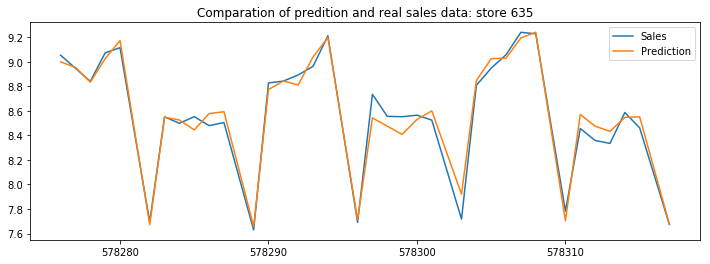

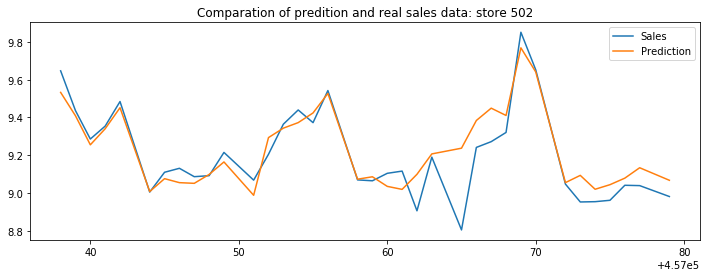

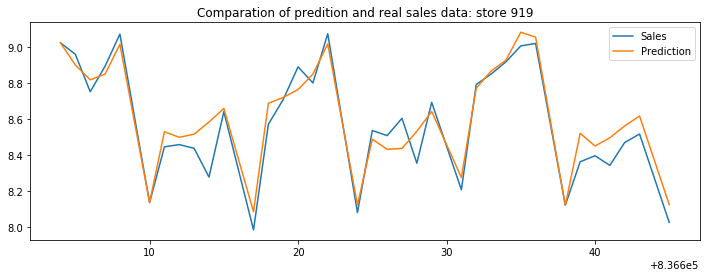

In [44]:
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
stores=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in stores:
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))

根据视图可以看到看出预测值与实际值之间的偏差

** 分析偏差最大的10个预测结果 ** 

In [45]:
print ('分析偏差均值：'+str(res.Error.mean()))
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10][['Sales','Prediction','Ratio','Error','Weight']]

分析偏差均值：0.010170075010124277


,Sales,Prediction,Ratio,Error,Weight
264207,6.920672,8.551436,1.235637,0.235637,0.809299
711449,7.260523,8.587445,1.182759,0.182759,0.845481
827582,8.174139,9.547163,1.167972,0.167972,0.856185
797965,9.596215,8.217957,0.856375,0.143625,1.167713
827591,10.634701,9.167319,0.862019,0.137981,1.160067
264218,10.280622,9.037091,0.879041,0.120959,1.137603
797963,10.215777,9.048552,0.885743,0.114257,1.128996
264213,7.406711,8.252926,1.114250,0.114250,0.897465
827590,10.310252,9.132682,0.885786,0.114214,1.128940
711448,7.714677,8.568583,1.110686,0.110686,0.900345


从分析结果来看，我们的初始模型已经可以比较好的预测hold-out数据集的销售趋势，但是相对真实值，我们的模型的预测值整体要偏高一些。
从对偏差数据分析来看，偏差最大的10个数据也是明显偏高。因此我们可以以hold-out数据集为标准对模型进行偏差校正。
 

#### 校正系数：校正整体偏差

校正前：0.1262278132940301
权重校正
RMSPE (0.990,0.130130)
RMSPE (0.991,0.127224)
RMSPE (0.992,0.124787)
RMSPE (0.993,0.122862)
RMSPE (0.994,0.121489)
RMSPE (0.995,0.120703)
RMSPE (0.996,0.120532)
RMSPE (0.997,0.120994)
RMSPE (0.998,0.122099)
RMSPE (0.999,0.123847)
RMSPE (1.000,0.126228)
RMSPE (1.001,0.129223)
RMSPE (1.002,0.132808)
RMSPE (1.003,0.136954)
RMSPE (1.004,0.141625)
RMSPE (1.005,0.146791)
RMSPE (1.006,0.152414)
RMSPE (1.007,0.158462)
RMSPE (1.008,0.164904)
RMSPE (1.009,0.171710)
最佳参数:0.996    0.120532
dtype: float64


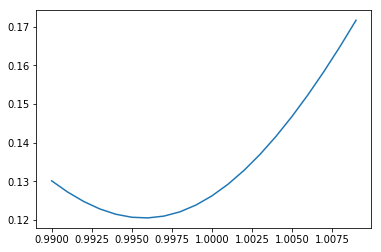

In [46]:
#7.1偏差整体校正优化
print('校正前：'+ str(error))
print("权重校正")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE ({:.3f},{:.6f})'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('最佳参数:{}'.format(BS))


当校正系数为0.996时，hold-out集的RMSPE得分最低：0.120532，相对于初始模型 0.126228得分有很大的提升。

** 将整体最佳参数追加至数据集作为字段属性 ** 

In [47]:
factor =sorted(Score.items(),key = lambda x:x[1],reverse = True)[-1][0]

res['factor'] = [factor]*len(res)

#### 下面我们进行细致校正，以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数

In [64]:
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
   
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())
   



#计算校正后整体数据的RMSPE得分

In [49]:
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.113504


细致校正后的hold-out集的得分为0.113504，相对于整体校正的0.120532的得分又有不小的提高

### 特征重要性

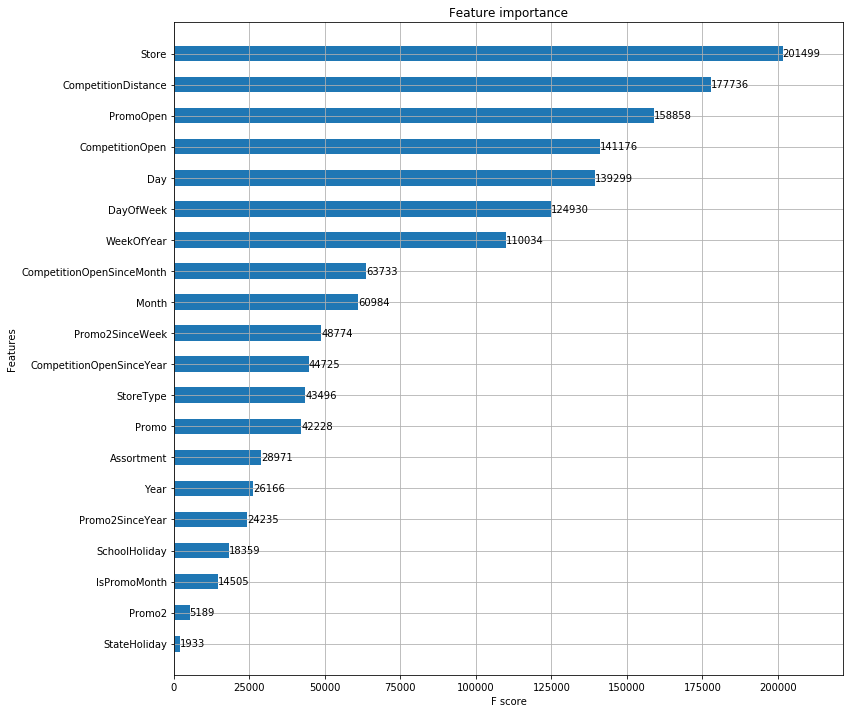

In [51]:
from xgboost import plot_importance
fig,ax = plt.subplots(figsize=(12,12))
plot_importance(gbm, height=0.5, ax=ax)

** 最后我们运行一次完整的数据，看一下结果,循环跑的话时间太长，这里只跑一次 **

In [53]:
all_x = pd.concat([ho_xtrain, ho_xtest])
all_y = pd.concat([ho_ytrain, ho_ytest])
all_matrix = xgb.DMatrix(all_x, all_y)
watchlist_all = [(all_matrix, 'all'), (dvalid, 'valid')]
print ('XGBoost Model Train Start....')
start_time = time()
model_opt_alldate = xgb.train(params, all_matrix, 6000, evals=watchlist_all, 
                  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
print ('XGBoost Model Train End, Time: {:4f} H....'.format((time()-start_time)/3600))

XGBoost Model Train Start....
[0]	all-rmse:8.02109	valid-rmse:8.02776	all-rmspe:0.999809	valid-rmspe:0.999811
Multiple eval metrics have been passed: 'valid-rmspe' will be used for early stopping.

Will train until valid-rmspe hasn't improved in 100 rounds.
[1]	all-rmse:7.78092	valid-rmse:7.78806	all-rmspe:0.999711	valid-rmspe:0.999714
[2]	all-rmse:7.54798	valid-rmse:7.55519	all-rmspe:0.999591	valid-rmspe:0.999596
[3]	all-rmse:7.32213	valid-rmse:7.3291	all-rmspe:0.999444	valid-rmspe:0.99945
[4]	all-rmse:7.103	valid-rmse:7.11007	all-rmspe:0.999267	valid-rmspe:0.999275
[5]	all-rmse:6.89042	valid-rmse:6.89811	all-rmspe:0.999053	valid-rmspe:0.999066
[6]	all-rmse:6.68428	valid-rmse:6.69159	all-rmspe:0.998799	valid-rmspe:0.998814
[7]	all-rmse:6.48436	valid-rmse:6.49141	all-rmspe:0.998497	valid-rmspe:0.998515
[8]	all-rmse:6.29037	valid-rmse:6.29752	all-rmspe:0.998141	valid-rmspe:0.998164
[9]	all-rmse:6.10222	valid-rmse:6.10962	all-rmspe:0.997724	valid-rmspe:0.997752
[10]	all-rmse:5.91977	vali

[99]	all-rmse:0.470113	valid-rmse:0.469546	all-rmspe:0.36847	valid-rmspe:0.355115
[100]	all-rmse:0.46008	valid-rmse:0.459316	all-rmspe:0.363084	valid-rmspe:0.348974
[101]	all-rmse:0.450073	valid-rmse:0.449172	all-rmspe:0.357753	valid-rmspe:0.342961
[102]	all-rmse:0.440402	valid-rmse:0.439349	all-rmspe:0.352584	valid-rmspe:0.337098
[103]	all-rmse:0.431352	valid-rmse:0.430302	all-rmspe:0.347839	valid-rmspe:0.33163
[104]	all-rmse:0.422789	valid-rmse:0.421583	all-rmspe:0.343309	valid-rmspe:0.326352
[105]	all-rmse:0.414291	valid-rmse:0.413079	all-rmspe:0.338835	valid-rmspe:0.321226
[106]	all-rmse:0.406194	valid-rmse:0.404855	all-rmspe:0.33459	valid-rmspe:0.316277
[107]	all-rmse:0.39845	valid-rmse:0.397185	all-rmspe:0.330534	valid-rmspe:0.311643
[108]	all-rmse:0.390605	valid-rmse:0.389169	all-rmspe:0.326391	valid-rmspe:0.306767
[109]	all-rmse:0.38308	valid-rmse:0.381472	all-rmspe:0.322395	valid-rmspe:0.302138
[110]	all-rmse:0.376275	valid-rmse:0.37468	all-rmspe:0.318934	valid-rmspe:0.298035


[198]	all-rmse:0.200753	valid-rmse:0.198352	all-rmspe:0.25063	valid-rmspe:0.204264
[199]	all-rmse:0.200186	valid-rmse:0.197832	all-rmspe:0.250317	valid-rmspe:0.203944
[200]	all-rmse:0.19988	valid-rmse:0.197516	all-rmspe:0.250186	valid-rmspe:0.203825
[201]	all-rmse:0.199525	valid-rmse:0.197174	all-rmspe:0.250043	valid-rmspe:0.203618
[202]	all-rmse:0.199386	valid-rmse:0.197019	all-rmspe:0.250105	valid-rmspe:0.203649
[203]	all-rmse:0.198983	valid-rmse:0.196631	all-rmspe:0.249913	valid-rmspe:0.203441
[204]	all-rmse:0.198701	valid-rmse:0.196373	all-rmspe:0.249834	valid-rmspe:0.203298
[205]	all-rmse:0.198267	valid-rmse:0.19595	all-rmspe:0.249475	valid-rmspe:0.202978
[206]	all-rmse:0.197869	valid-rmse:0.195582	all-rmspe:0.249307	valid-rmspe:0.202685
[207]	all-rmse:0.197285	valid-rmse:0.194981	all-rmspe:0.248891	valid-rmspe:0.202162
[208]	all-rmse:0.196786	valid-rmse:0.194474	all-rmspe:0.248607	valid-rmspe:0.201789
[209]	all-rmse:0.196444	valid-rmse:0.194144	all-rmspe:0.24846	valid-rmspe:0.201

[296]	all-rmse:0.162975	valid-rmse:0.161415	all-rmspe:0.220049	valid-rmspe:0.170539
[297]	all-rmse:0.162785	valid-rmse:0.161218	all-rmspe:0.219891	valid-rmspe:0.170337
[298]	all-rmse:0.162573	valid-rmse:0.161003	all-rmspe:0.219719	valid-rmspe:0.170129
[299]	all-rmse:0.162106	valid-rmse:0.160545	all-rmspe:0.219207	valid-rmspe:0.169585
[300]	all-rmse:0.161831	valid-rmse:0.1603	all-rmspe:0.219015	valid-rmspe:0.169321
[301]	all-rmse:0.161707	valid-rmse:0.160182	all-rmspe:0.218811	valid-rmspe:0.169187
[302]	all-rmse:0.161236	valid-rmse:0.159651	all-rmspe:0.218486	valid-rmspe:0.16861
[303]	all-rmse:0.16113	valid-rmse:0.159535	all-rmspe:0.218395	valid-rmspe:0.168494
[304]	all-rmse:0.161006	valid-rmse:0.159409	all-rmspe:0.218243	valid-rmspe:0.168347
[305]	all-rmse:0.160569	valid-rmse:0.158954	all-rmspe:0.21788	valid-rmspe:0.167901
[306]	all-rmse:0.160499	valid-rmse:0.158884	all-rmspe:0.217752	valid-rmspe:0.167831
[307]	all-rmse:0.160043	valid-rmse:0.158441	all-rmspe:0.21732	valid-rmspe:0.16733

[395]	all-rmse:0.140546	valid-rmse:0.138746	all-rmspe:0.197962	valid-rmspe:0.146327
[396]	all-rmse:0.140515	valid-rmse:0.1387	all-rmspe:0.197953	valid-rmspe:0.146291
[397]	all-rmse:0.140317	valid-rmse:0.138491	all-rmspe:0.197901	valid-rmspe:0.146074
[398]	all-rmse:0.140189	valid-rmse:0.138352	all-rmspe:0.197754	valid-rmspe:0.14594
[399]	all-rmse:0.14012	valid-rmse:0.138285	all-rmspe:0.197688	valid-rmspe:0.145864
[400]	all-rmse:0.139987	valid-rmse:0.138165	all-rmspe:0.197526	valid-rmspe:0.145731
[401]	all-rmse:0.139875	valid-rmse:0.138042	all-rmspe:0.197439	valid-rmspe:0.14561
[402]	all-rmse:0.139827	valid-rmse:0.137994	all-rmspe:0.197418	valid-rmspe:0.14556
[403]	all-rmse:0.13975	valid-rmse:0.137921	all-rmspe:0.197406	valid-rmspe:0.145488
[404]	all-rmse:0.139433	valid-rmse:0.137608	all-rmspe:0.197171	valid-rmspe:0.14512
[405]	all-rmse:0.139331	valid-rmse:0.1375	all-rmspe:0.196958	valid-rmspe:0.145007
[406]	all-rmse:0.139126	valid-rmse:0.137296	all-rmspe:0.196761	valid-rmspe:0.144803
[4

[494]	all-rmse:0.126365	valid-rmse:0.124459	all-rmspe:0.185181	valid-rmspe:0.130995
[495]	all-rmse:0.126218	valid-rmse:0.124307	all-rmspe:0.185059	valid-rmspe:0.130828
[496]	all-rmse:0.126102	valid-rmse:0.124179	all-rmspe:0.184965	valid-rmspe:0.1307
[497]	all-rmse:0.125979	valid-rmse:0.124059	all-rmspe:0.185056	valid-rmspe:0.130575
[498]	all-rmse:0.125733	valid-rmse:0.123832	all-rmspe:0.184816	valid-rmspe:0.13032
[499]	all-rmse:0.125614	valid-rmse:0.123714	all-rmspe:0.18474	valid-rmspe:0.130188
[500]	all-rmse:0.125516	valid-rmse:0.12361	all-rmspe:0.184642	valid-rmspe:0.13008
[501]	all-rmse:0.1254	valid-rmse:0.123485	all-rmspe:0.18455	valid-rmspe:0.129939
[502]	all-rmse:0.125288	valid-rmse:0.123358	all-rmspe:0.18446	valid-rmspe:0.1298
[503]	all-rmse:0.125152	valid-rmse:0.123219	all-rmspe:0.184355	valid-rmspe:0.129645
[504]	all-rmse:0.124954	valid-rmse:0.123028	all-rmspe:0.184212	valid-rmspe:0.129437
[505]	all-rmse:0.124805	valid-rmse:0.122863	all-rmspe:0.184101	valid-rmspe:0.129257
[506

[593]	all-rmse:0.116288	valid-rmse:0.114015	all-rmspe:0.175891	valid-rmspe:0.119619
[594]	all-rmse:0.116238	valid-rmse:0.113965	all-rmspe:0.175841	valid-rmspe:0.119562
[595]	all-rmse:0.116169	valid-rmse:0.113871	all-rmspe:0.175792	valid-rmspe:0.119462
[596]	all-rmse:0.116048	valid-rmse:0.113749	all-rmspe:0.175692	valid-rmspe:0.119332
[597]	all-rmse:0.115949	valid-rmse:0.113662	all-rmspe:0.175615	valid-rmspe:0.119242
[598]	all-rmse:0.115858	valid-rmse:0.113572	all-rmspe:0.175547	valid-rmspe:0.119141
[599]	all-rmse:0.115778	valid-rmse:0.113443	all-rmspe:0.175435	valid-rmspe:0.118982
[600]	all-rmse:0.115724	valid-rmse:0.113412	all-rmspe:0.175379	valid-rmspe:0.118951
[601]	all-rmse:0.115628	valid-rmse:0.11332	all-rmspe:0.175308	valid-rmspe:0.118859
[602]	all-rmse:0.115438	valid-rmse:0.113125	all-rmspe:0.175164	valid-rmspe:0.118635
[603]	all-rmse:0.115394	valid-rmse:0.112991	all-rmspe:0.175095	valid-rmspe:0.118491
[604]	all-rmse:0.115347	valid-rmse:0.112931	all-rmspe:0.175023	valid-rmspe:0.

[692]	all-rmse:0.109687	valid-rmse:0.107085	all-rmspe:0.169208	valid-rmspe:0.112234
[693]	all-rmse:0.109673	valid-rmse:0.107068	all-rmspe:0.169033	valid-rmspe:0.112218
[694]	all-rmse:0.109579	valid-rmse:0.106966	all-rmspe:0.16891	valid-rmspe:0.112116
[695]	all-rmse:0.109541	valid-rmse:0.106925	all-rmspe:0.168856	valid-rmspe:0.112073
[696]	all-rmse:0.109461	valid-rmse:0.106844	all-rmspe:0.168781	valid-rmspe:0.111985
[697]	all-rmse:0.109322	valid-rmse:0.106707	all-rmspe:0.168654	valid-rmspe:0.111837
[698]	all-rmse:0.109242	valid-rmse:0.106627	all-rmspe:0.168594	valid-rmspe:0.111741
[699]	all-rmse:0.109218	valid-rmse:0.106605	all-rmspe:0.168576	valid-rmspe:0.111718
[700]	all-rmse:0.109152	valid-rmse:0.106503	all-rmspe:0.168502	valid-rmspe:0.111613
[701]	all-rmse:0.109094	valid-rmse:0.106447	all-rmspe:0.168408	valid-rmspe:0.111555
[702]	all-rmse:0.109012	valid-rmse:0.10637	all-rmspe:0.168298	valid-rmspe:0.111469
[703]	all-rmse:0.108927	valid-rmse:0.106282	all-rmspe:0.168239	valid-rmspe:0.1

[790]	all-rmse:0.104943	valid-rmse:0.101695	all-rmspe:0.164254	valid-rmspe:0.106377
[791]	all-rmse:0.104929	valid-rmse:0.10168	all-rmspe:0.164244	valid-rmspe:0.106364
[792]	all-rmse:0.104909	valid-rmse:0.101549	all-rmspe:0.164236	valid-rmspe:0.106224
[793]	all-rmse:0.104893	valid-rmse:0.101531	all-rmspe:0.164305	valid-rmspe:0.106206
[794]	all-rmse:0.104831	valid-rmse:0.101485	all-rmspe:0.164258	valid-rmspe:0.106153
[795]	all-rmse:0.104776	valid-rmse:0.101427	all-rmspe:0.164054	valid-rmspe:0.106093
[796]	all-rmse:0.104717	valid-rmse:0.10136	all-rmspe:0.163994	valid-rmspe:0.106023
[797]	all-rmse:0.104673	valid-rmse:0.101305	all-rmspe:0.163962	valid-rmspe:0.105964
[798]	all-rmse:0.10463	valid-rmse:0.101253	all-rmspe:0.163927	valid-rmspe:0.105916
[799]	all-rmse:0.1046	valid-rmse:0.10121	all-rmspe:0.163845	valid-rmspe:0.105879
[800]	all-rmse:0.10456	valid-rmse:0.101158	all-rmspe:0.163806	valid-rmspe:0.105823
[801]	all-rmse:0.104513	valid-rmse:0.101103	all-rmspe:0.163751	valid-rmspe:0.105759

[889]	all-rmse:0.101346	valid-rmse:0.097659	all-rmspe:0.16004	valid-rmspe:0.102108
[890]	all-rmse:0.101327	valid-rmse:0.097632	all-rmspe:0.160025	valid-rmspe:0.102069
[891]	all-rmse:0.1013	valid-rmse:0.097601	all-rmspe:0.160002	valid-rmspe:0.10204
[892]	all-rmse:0.101261	valid-rmse:0.097589	all-rmspe:0.159918	valid-rmspe:0.102026
[893]	all-rmse:0.101225	valid-rmse:0.097551	all-rmspe:0.159894	valid-rmspe:0.101985
[894]	all-rmse:0.101199	valid-rmse:0.097533	all-rmspe:0.15979	valid-rmspe:0.101965
[895]	all-rmse:0.101162	valid-rmse:0.097495	all-rmspe:0.159759	valid-rmspe:0.101927
[896]	all-rmse:0.10115	valid-rmse:0.097451	all-rmspe:0.159746	valid-rmspe:0.101882
[897]	all-rmse:0.101139	valid-rmse:0.09744	all-rmspe:0.159735	valid-rmspe:0.101874
[898]	all-rmse:0.101128	valid-rmse:0.09743	all-rmspe:0.159727	valid-rmspe:0.101863
[899]	all-rmse:0.101102	valid-rmse:0.097404	all-rmspe:0.159708	valid-rmspe:0.101826
[900]	all-rmse:0.101064	valid-rmse:0.097387	all-rmspe:0.159645	valid-rmspe:0.101806


[988]	all-rmse:0.098578	valid-rmse:0.09495	all-rmspe:0.156775	valid-rmspe:0.099294
[989]	all-rmse:0.098562	valid-rmse:0.094933	all-rmspe:0.156762	valid-rmspe:0.099277
[990]	all-rmse:0.098507	valid-rmse:0.094887	all-rmspe:0.156612	valid-rmspe:0.099228
[991]	all-rmse:0.098481	valid-rmse:0.094821	all-rmspe:0.156584	valid-rmspe:0.099149
[992]	all-rmse:0.098454	valid-rmse:0.094793	all-rmspe:0.156566	valid-rmspe:0.099118
[993]	all-rmse:0.098422	valid-rmse:0.094752	all-rmspe:0.156534	valid-rmspe:0.099075
[994]	all-rmse:0.098386	valid-rmse:0.094722	all-rmspe:0.156527	valid-rmspe:0.099039
[995]	all-rmse:0.098362	valid-rmse:0.094682	all-rmspe:0.156512	valid-rmspe:0.099
[996]	all-rmse:0.098339	valid-rmse:0.094657	all-rmspe:0.156492	valid-rmspe:0.098974
[997]	all-rmse:0.098315	valid-rmse:0.094635	all-rmspe:0.156312	valid-rmspe:0.098954
[998]	all-rmse:0.098285	valid-rmse:0.094608	all-rmspe:0.156282	valid-rmspe:0.098926
[999]	all-rmse:0.098275	valid-rmse:0.094604	all-rmspe:0.156293	valid-rmspe:0.098

[1085]	all-rmse:0.096356	valid-rmse:0.092598	all-rmspe:0.152949	valid-rmspe:0.096843
[1086]	all-rmse:0.096331	valid-rmse:0.09257	all-rmspe:0.153003	valid-rmspe:0.096814
[1087]	all-rmse:0.096306	valid-rmse:0.092548	all-rmspe:0.152983	valid-rmspe:0.096792
[1088]	all-rmse:0.096275	valid-rmse:0.092505	all-rmspe:0.152948	valid-rmspe:0.096751
[1089]	all-rmse:0.096244	valid-rmse:0.092477	all-rmspe:0.152813	valid-rmspe:0.096724
[1090]	all-rmse:0.096231	valid-rmse:0.092472	all-rmspe:0.152855	valid-rmspe:0.096719
[1091]	all-rmse:0.096223	valid-rmse:0.092464	all-rmspe:0.152841	valid-rmspe:0.09671
[1092]	all-rmse:0.096209	valid-rmse:0.092448	all-rmspe:0.152831	valid-rmspe:0.096695
[1093]	all-rmse:0.096201	valid-rmse:0.092442	all-rmspe:0.152819	valid-rmspe:0.09669
[1094]	all-rmse:0.09619	valid-rmse:0.09244	all-rmspe:0.152808	valid-rmspe:0.096688
[1095]	all-rmse:0.096154	valid-rmse:0.092404	all-rmspe:0.152782	valid-rmspe:0.096631
[1096]	all-rmse:0.096133	valid-rmse:0.09238	all-rmspe:0.152764	valid-r

[1182]	all-rmse:0.094449	valid-rmse:0.090668	all-rmspe:0.150237	valid-rmspe:0.094786
[1183]	all-rmse:0.094427	valid-rmse:0.090648	all-rmspe:0.150218	valid-rmspe:0.094768
[1184]	all-rmse:0.094411	valid-rmse:0.090629	all-rmspe:0.150304	valid-rmspe:0.094746
[1185]	all-rmse:0.094404	valid-rmse:0.090594	all-rmspe:0.150308	valid-rmspe:0.094708
[1186]	all-rmse:0.094397	valid-rmse:0.090593	all-rmspe:0.150303	valid-rmspe:0.094708
[1187]	all-rmse:0.094386	valid-rmse:0.090576	all-rmspe:0.150295	valid-rmspe:0.094682
[1188]	all-rmse:0.094366	valid-rmse:0.090563	all-rmspe:0.15028	valid-rmspe:0.094666
[1189]	all-rmse:0.094349	valid-rmse:0.090544	all-rmspe:0.150271	valid-rmspe:0.094648
[1190]	all-rmse:0.094324	valid-rmse:0.090519	all-rmspe:0.15024	valid-rmspe:0.094615
[1191]	all-rmse:0.094315	valid-rmse:0.090513	all-rmspe:0.150229	valid-rmspe:0.094609
[1192]	all-rmse:0.094304	valid-rmse:0.090503	all-rmspe:0.150087	valid-rmspe:0.094598
[1193]	all-rmse:0.094297	valid-rmse:0.090492	all-rmspe:0.150075	val

[1279]	all-rmse:0.09282	valid-rmse:0.088788	all-rmspe:0.14765	valid-rmspe:0.092762
[1280]	all-rmse:0.0928	valid-rmse:0.088769	all-rmspe:0.147524	valid-rmspe:0.092742
[1281]	all-rmse:0.092779	valid-rmse:0.088747	all-rmspe:0.147508	valid-rmspe:0.092721
[1282]	all-rmse:0.092769	valid-rmse:0.08874	all-rmspe:0.147497	valid-rmspe:0.092712
[1283]	all-rmse:0.092755	valid-rmse:0.088727	all-rmspe:0.147486	valid-rmspe:0.0927
[1284]	all-rmse:0.092727	valid-rmse:0.0887	all-rmspe:0.147457	valid-rmspe:0.092668
[1285]	all-rmse:0.092712	valid-rmse:0.08869	all-rmspe:0.147446	valid-rmspe:0.092657
[1286]	all-rmse:0.092696	valid-rmse:0.088679	all-rmspe:0.147418	valid-rmspe:0.092646
[1287]	all-rmse:0.092678	valid-rmse:0.088663	all-rmspe:0.147404	valid-rmspe:0.09263
[1288]	all-rmse:0.09267	valid-rmse:0.088638	all-rmspe:0.147394	valid-rmspe:0.09259
[1289]	all-rmse:0.09266	valid-rmse:0.088628	all-rmspe:0.147401	valid-rmspe:0.09258
[1290]	all-rmse:0.092654	valid-rmse:0.088621	all-rmspe:0.147382	valid-rmspe:0.09

[1377]	all-rmse:0.091354	valid-rmse:0.087214	all-rmspe:0.144901	valid-rmspe:0.091117
[1378]	all-rmse:0.091341	valid-rmse:0.087202	all-rmspe:0.14489	valid-rmspe:0.091104
[1379]	all-rmse:0.091334	valid-rmse:0.087187	all-rmspe:0.144883	valid-rmspe:0.091085
[1380]	all-rmse:0.091328	valid-rmse:0.087181	all-rmspe:0.144878	valid-rmspe:0.091078
[1381]	all-rmse:0.091314	valid-rmse:0.087163	all-rmspe:0.144861	valid-rmspe:0.09106
[1382]	all-rmse:0.091289	valid-rmse:0.087143	all-rmspe:0.144845	valid-rmspe:0.091037
[1383]	all-rmse:0.091282	valid-rmse:0.087129	all-rmspe:0.144839	valid-rmspe:0.091019
[1384]	all-rmse:0.091273	valid-rmse:0.087114	all-rmspe:0.144832	valid-rmspe:0.091002
[1385]	all-rmse:0.091262	valid-rmse:0.0871	all-rmspe:0.144814	valid-rmspe:0.090991
[1386]	all-rmse:0.091252	valid-rmse:0.087087	all-rmspe:0.144613	valid-rmspe:0.090977
[1387]	all-rmse:0.091238	valid-rmse:0.087061	all-rmspe:0.144602	valid-rmspe:0.090951
[1388]	all-rmse:0.091224	valid-rmse:0.087045	all-rmspe:0.144591	valid

[1474]	all-rmse:0.090059	valid-rmse:0.085826	all-rmspe:0.142679	valid-rmspe:0.089678
[1475]	all-rmse:0.09005	valid-rmse:0.085819	all-rmspe:0.142666	valid-rmspe:0.08967
[1476]	all-rmse:0.090037	valid-rmse:0.085802	all-rmspe:0.142574	valid-rmspe:0.089648
[1477]	all-rmse:0.09003	valid-rmse:0.08578	all-rmspe:0.142569	valid-rmspe:0.089649
[1478]	all-rmse:0.090019	valid-rmse:0.085771	all-rmspe:0.14256	valid-rmspe:0.089641
[1479]	all-rmse:0.090004	valid-rmse:0.085758	all-rmspe:0.142543	valid-rmspe:0.089627
[1480]	all-rmse:0.089995	valid-rmse:0.085749	all-rmspe:0.14254	valid-rmspe:0.089617
[1481]	all-rmse:0.089976	valid-rmse:0.085732	all-rmspe:0.142525	valid-rmspe:0.089602
[1482]	all-rmse:0.089964	valid-rmse:0.08572	all-rmspe:0.142509	valid-rmspe:0.08959
[1483]	all-rmse:0.089949	valid-rmse:0.085691	all-rmspe:0.142495	valid-rmspe:0.08955
[1484]	all-rmse:0.08994	valid-rmse:0.085681	all-rmspe:0.142487	valid-rmspe:0.08954
[1485]	all-rmse:0.089929	valid-rmse:0.085669	all-rmspe:0.142284	valid-rmspe:

[1571]	all-rmse:0.088916	valid-rmse:0.084494	all-rmspe:0.140267	valid-rmspe:0.08827
[1572]	all-rmse:0.088902	valid-rmse:0.084477	all-rmspe:0.140244	valid-rmspe:0.088251
[1573]	all-rmse:0.088887	valid-rmse:0.084465	all-rmspe:0.140182	valid-rmspe:0.088238
[1574]	all-rmse:0.088865	valid-rmse:0.084445	all-rmspe:0.140096	valid-rmspe:0.088217
[1575]	all-rmse:0.088856	valid-rmse:0.084433	all-rmspe:0.140092	valid-rmspe:0.088204
[1576]	all-rmse:0.088846	valid-rmse:0.084425	all-rmspe:0.140085	valid-rmspe:0.088196
[1577]	all-rmse:0.088841	valid-rmse:0.08442	all-rmspe:0.140082	valid-rmspe:0.088189
[1578]	all-rmse:0.088829	valid-rmse:0.084415	all-rmspe:0.140063	valid-rmspe:0.088183
[1579]	all-rmse:0.088814	valid-rmse:0.084404	all-rmspe:0.140052	valid-rmspe:0.088168
[1580]	all-rmse:0.088805	valid-rmse:0.084392	all-rmspe:0.139895	valid-rmspe:0.088155
[1581]	all-rmse:0.088789	valid-rmse:0.084366	all-rmspe:0.139881	valid-rmspe:0.088132
[1582]	all-rmse:0.088769	valid-rmse:0.084349	all-rmspe:0.139868	val

[1668]	all-rmse:0.08781	valid-rmse:0.083319	all-rmspe:0.136928	valid-rmspe:0.087033
[1669]	all-rmse:0.087798	valid-rmse:0.083309	all-rmspe:0.136919	valid-rmspe:0.087019
[1670]	all-rmse:0.087788	valid-rmse:0.083301	all-rmspe:0.13691	valid-rmspe:0.087011
[1671]	all-rmse:0.08778	valid-rmse:0.083288	all-rmspe:0.136902	valid-rmspe:0.086999
[1672]	all-rmse:0.087772	valid-rmse:0.083284	all-rmspe:0.136882	valid-rmspe:0.086994
[1673]	all-rmse:0.087755	valid-rmse:0.083271	all-rmspe:0.136869	valid-rmspe:0.086981
[1674]	all-rmse:0.087745	valid-rmse:0.08326	all-rmspe:0.136862	valid-rmspe:0.08697
[1675]	all-rmse:0.087734	valid-rmse:0.083252	all-rmspe:0.136852	valid-rmspe:0.086963
[1676]	all-rmse:0.087724	valid-rmse:0.083243	all-rmspe:0.136834	valid-rmspe:0.08696
[1677]	all-rmse:0.087708	valid-rmse:0.083227	all-rmspe:0.136758	valid-rmspe:0.086945
[1678]	all-rmse:0.087696	valid-rmse:0.083215	all-rmspe:0.136783	valid-rmspe:0.08693
[1679]	all-rmse:0.087688	valid-rmse:0.083207	all-rmspe:0.136777	valid-rm

[1765]	all-rmse:0.086882	valid-rmse:0.082302	all-rmspe:0.134876	valid-rmspe:0.085927
[1766]	all-rmse:0.086876	valid-rmse:0.082294	all-rmspe:0.134872	valid-rmspe:0.085916
[1767]	all-rmse:0.086865	valid-rmse:0.082283	all-rmspe:0.134863	valid-rmspe:0.085906
[1768]	all-rmse:0.086848	valid-rmse:0.082268	all-rmspe:0.134724	valid-rmspe:0.085891
[1769]	all-rmse:0.086839	valid-rmse:0.082259	all-rmspe:0.134604	valid-rmspe:0.085879
[1770]	all-rmse:0.08683	valid-rmse:0.082248	all-rmspe:0.134593	valid-rmspe:0.085867
[1771]	all-rmse:0.086821	valid-rmse:0.082239	all-rmspe:0.134581	valid-rmspe:0.085857
[1772]	all-rmse:0.086813	valid-rmse:0.08223	all-rmspe:0.134553	valid-rmspe:0.085847
[1773]	all-rmse:0.086807	valid-rmse:0.082224	all-rmspe:0.134549	valid-rmspe:0.085842
[1774]	all-rmse:0.086801	valid-rmse:0.082211	all-rmspe:0.134545	valid-rmspe:0.085828
[1775]	all-rmse:0.086782	valid-rmse:0.082191	all-rmspe:0.13444	valid-rmspe:0.085807
[1776]	all-rmse:0.086778	valid-rmse:0.082188	all-rmspe:0.134437	vali

[1862]	all-rmse:0.086027	valid-rmse:0.081316	all-rmspe:0.132361	valid-rmspe:0.08492
[1863]	all-rmse:0.086019	valid-rmse:0.081301	all-rmspe:0.132348	valid-rmspe:0.084905
[1864]	all-rmse:0.086013	valid-rmse:0.081294	all-rmspe:0.132343	valid-rmspe:0.084899
[1865]	all-rmse:0.086004	valid-rmse:0.081286	all-rmspe:0.132335	valid-rmspe:0.08489
[1866]	all-rmse:0.085997	valid-rmse:0.081279	all-rmspe:0.132331	valid-rmspe:0.084878
[1867]	all-rmse:0.085991	valid-rmse:0.081275	all-rmspe:0.132328	valid-rmspe:0.084873
[1868]	all-rmse:0.085975	valid-rmse:0.081254	all-rmspe:0.132317	valid-rmspe:0.084851
[1869]	all-rmse:0.085965	valid-rmse:0.081246	all-rmspe:0.132307	valid-rmspe:0.084844
[1870]	all-rmse:0.085957	valid-rmse:0.081239	all-rmspe:0.132298	valid-rmspe:0.084836
[1871]	all-rmse:0.085949	valid-rmse:0.081227	all-rmspe:0.132286	valid-rmspe:0.084824
[1872]	all-rmse:0.08594	valid-rmse:0.081222	all-rmspe:0.132282	valid-rmspe:0.084818
[1873]	all-rmse:0.085934	valid-rmse:0.08121	all-rmspe:0.132278	valid

[1959]	all-rmse:0.085189	valid-rmse:0.080452	all-rmspe:0.13068	valid-rmspe:0.084008
[1960]	all-rmse:0.085184	valid-rmse:0.080449	all-rmspe:0.130676	valid-rmspe:0.084003
[1961]	all-rmse:0.085179	valid-rmse:0.080445	all-rmspe:0.130671	valid-rmspe:0.083999
[1962]	all-rmse:0.085175	valid-rmse:0.08044	all-rmspe:0.130665	valid-rmspe:0.083994
[1963]	all-rmse:0.085166	valid-rmse:0.080423	all-rmspe:0.130649	valid-rmspe:0.083977
[1964]	all-rmse:0.085152	valid-rmse:0.080406	all-rmspe:0.130633	valid-rmspe:0.083959
[1965]	all-rmse:0.085141	valid-rmse:0.080394	all-rmspe:0.130624	valid-rmspe:0.083948
[1966]	all-rmse:0.085129	valid-rmse:0.080384	all-rmspe:0.130607	valid-rmspe:0.083933
[1967]	all-rmse:0.085125	valid-rmse:0.080378	all-rmspe:0.130606	valid-rmspe:0.083927
[1968]	all-rmse:0.085119	valid-rmse:0.080369	all-rmspe:0.130602	valid-rmspe:0.083913
[1969]	all-rmse:0.085114	valid-rmse:0.080365	all-rmspe:0.130597	valid-rmspe:0.083909
[1970]	all-rmse:0.08511	valid-rmse:0.080363	all-rmspe:0.130591	vali

[2056]	all-rmse:0.084469	valid-rmse:0.079639	all-rmspe:0.127976	valid-rmspe:0.083111
[2057]	all-rmse:0.084464	valid-rmse:0.07963	all-rmspe:0.127976	valid-rmspe:0.083099
[2058]	all-rmse:0.084459	valid-rmse:0.079622	all-rmspe:0.127973	valid-rmspe:0.083089
[2059]	all-rmse:0.084453	valid-rmse:0.079616	all-rmspe:0.127968	valid-rmspe:0.083086
[2060]	all-rmse:0.084447	valid-rmse:0.079614	all-rmspe:0.127965	valid-rmspe:0.083084
[2061]	all-rmse:0.084444	valid-rmse:0.079613	all-rmspe:0.12793	valid-rmspe:0.083083
[2062]	all-rmse:0.084438	valid-rmse:0.079608	all-rmspe:0.127876	valid-rmspe:0.083077
[2063]	all-rmse:0.084429	valid-rmse:0.079607	all-rmspe:0.127865	valid-rmspe:0.083076
[2064]	all-rmse:0.084424	valid-rmse:0.079604	all-rmspe:0.12786	valid-rmspe:0.083074
[2065]	all-rmse:0.084412	valid-rmse:0.079591	all-rmspe:0.127851	valid-rmspe:0.083057
[2066]	all-rmse:0.084406	valid-rmse:0.079584	all-rmspe:0.127842	valid-rmspe:0.083051
[2067]	all-rmse:0.084394	valid-rmse:0.079575	all-rmspe:0.127839	vali

[2153]	all-rmse:0.083744	valid-rmse:0.078936	all-rmspe:0.126345	valid-rmspe:0.082326
[2154]	all-rmse:0.083739	valid-rmse:0.078932	all-rmspe:0.126342	valid-rmspe:0.08232
[2155]	all-rmse:0.083735	valid-rmse:0.078929	all-rmspe:0.126339	valid-rmspe:0.082316
[2156]	all-rmse:0.083725	valid-rmse:0.078922	all-rmspe:0.126328	valid-rmspe:0.08231
[2157]	all-rmse:0.08372	valid-rmse:0.078915	all-rmspe:0.126318	valid-rmspe:0.082302
[2158]	all-rmse:0.083713	valid-rmse:0.078913	all-rmspe:0.126305	valid-rmspe:0.082297
[2159]	all-rmse:0.083707	valid-rmse:0.07891	all-rmspe:0.126195	valid-rmspe:0.082294
[2160]	all-rmse:0.083703	valid-rmse:0.078904	all-rmspe:0.126192	valid-rmspe:0.082287
[2161]	all-rmse:0.083698	valid-rmse:0.078898	all-rmspe:0.126187	valid-rmspe:0.082281
[2162]	all-rmse:0.08369	valid-rmse:0.078889	all-rmspe:0.126182	valid-rmspe:0.082269
[2163]	all-rmse:0.083686	valid-rmse:0.078886	all-rmspe:0.126177	valid-rmspe:0.082265
[2164]	all-rmse:0.083682	valid-rmse:0.078882	all-rmspe:0.126174	valid-

[2250]	all-rmse:0.083093	valid-rmse:0.078241	all-rmspe:0.124027	valid-rmspe:0.081577
[2251]	all-rmse:0.083088	valid-rmse:0.078233	all-rmspe:0.124024	valid-rmspe:0.081557
[2252]	all-rmse:0.083084	valid-rmse:0.078228	all-rmspe:0.124019	valid-rmspe:0.081551
[2253]	all-rmse:0.083077	valid-rmse:0.07822	all-rmspe:0.124014	valid-rmspe:0.081543
[2254]	all-rmse:0.083071	valid-rmse:0.078215	all-rmspe:0.123866	valid-rmspe:0.081538
[2255]	all-rmse:0.083066	valid-rmse:0.078209	all-rmspe:0.12386	valid-rmspe:0.081532
[2256]	all-rmse:0.083062	valid-rmse:0.078182	all-rmspe:0.123858	valid-rmspe:0.081491
[2257]	all-rmse:0.083054	valid-rmse:0.078176	all-rmspe:0.123842	valid-rmspe:0.081486
[2258]	all-rmse:0.08304	valid-rmse:0.078158	all-rmspe:0.12383	valid-rmspe:0.081466
[2259]	all-rmse:0.083038	valid-rmse:0.078156	all-rmspe:0.123828	valid-rmspe:0.081464
[2260]	all-rmse:0.083034	valid-rmse:0.078151	all-rmspe:0.123868	valid-rmspe:0.081458
[2261]	all-rmse:0.083021	valid-rmse:0.078137	all-rmspe:0.123855	valid

[2347]	all-rmse:0.082487	valid-rmse:0.077559	all-rmspe:0.121792	valid-rmspe:0.080789
[2348]	all-rmse:0.082481	valid-rmse:0.077551	all-rmspe:0.121787	valid-rmspe:0.080781
[2349]	all-rmse:0.082477	valid-rmse:0.077548	all-rmspe:0.121786	valid-rmspe:0.080778
[2350]	all-rmse:0.082473	valid-rmse:0.077543	all-rmspe:0.121778	valid-rmspe:0.080773
[2351]	all-rmse:0.08247	valid-rmse:0.077536	all-rmspe:0.121737	valid-rmspe:0.080767
[2352]	all-rmse:0.08246	valid-rmse:0.077524	all-rmspe:0.121725	valid-rmspe:0.080746
[2353]	all-rmse:0.082454	valid-rmse:0.077519	all-rmspe:0.121712	valid-rmspe:0.080739
[2354]	all-rmse:0.082451	valid-rmse:0.077515	all-rmspe:0.121696	valid-rmspe:0.080736
[2355]	all-rmse:0.082446	valid-rmse:0.077511	all-rmspe:0.121666	valid-rmspe:0.080732
[2356]	all-rmse:0.08244	valid-rmse:0.077505	all-rmspe:0.121652	valid-rmspe:0.080726
[2357]	all-rmse:0.082435	valid-rmse:0.077503	all-rmspe:0.121643	valid-rmspe:0.080724
[2358]	all-rmse:0.08243	valid-rmse:0.077496	all-rmspe:0.12163	valid-

[2444]	all-rmse:0.081896	valid-rmse:0.076909	all-rmspe:0.119917	valid-rmspe:0.080027
[2445]	all-rmse:0.08189	valid-rmse:0.076903	all-rmspe:0.119913	valid-rmspe:0.080021
[2446]	all-rmse:0.081878	valid-rmse:0.076891	all-rmspe:0.119898	valid-rmspe:0.08001
[2447]	all-rmse:0.081875	valid-rmse:0.076888	all-rmspe:0.119894	valid-rmspe:0.080007
[2448]	all-rmse:0.08187	valid-rmse:0.076885	all-rmspe:0.119819	valid-rmspe:0.080003
[2449]	all-rmse:0.081854	valid-rmse:0.076871	all-rmspe:0.119802	valid-rmspe:0.079991
[2450]	all-rmse:0.081851	valid-rmse:0.07687	all-rmspe:0.119801	valid-rmspe:0.079991
[2451]	all-rmse:0.081846	valid-rmse:0.076864	all-rmspe:0.119796	valid-rmspe:0.079983
[2452]	all-rmse:0.08184	valid-rmse:0.076859	all-rmspe:0.119636	valid-rmspe:0.079979
[2453]	all-rmse:0.081835	valid-rmse:0.076855	all-rmspe:0.119633	valid-rmspe:0.079976
[2454]	all-rmse:0.081833	valid-rmse:0.076852	all-rmspe:0.119624	valid-rmspe:0.079973
[2455]	all-rmse:0.081825	valid-rmse:0.076847	all-rmspe:0.119614	valid-

[2541]	all-rmse:0.081315	valid-rmse:0.076309	all-rmspe:0.117869	valid-rmspe:0.079336
[2542]	all-rmse:0.08131	valid-rmse:0.076303	all-rmspe:0.117899	valid-rmspe:0.07933
[2543]	all-rmse:0.081304	valid-rmse:0.076295	all-rmspe:0.117844	valid-rmspe:0.079317
[2544]	all-rmse:0.081299	valid-rmse:0.076291	all-rmspe:0.117843	valid-rmspe:0.079313
[2545]	all-rmse:0.08129	valid-rmse:0.076281	all-rmspe:0.117805	valid-rmspe:0.079301
[2546]	all-rmse:0.081284	valid-rmse:0.076275	all-rmspe:0.117809	valid-rmspe:0.079293
[2547]	all-rmse:0.081276	valid-rmse:0.076269	all-rmspe:0.117775	valid-rmspe:0.079287
[2548]	all-rmse:0.081271	valid-rmse:0.076264	all-rmspe:0.11777	valid-rmspe:0.079281
[2549]	all-rmse:0.081268	valid-rmse:0.076263	all-rmspe:0.117775	valid-rmspe:0.079279
[2550]	all-rmse:0.081263	valid-rmse:0.076258	all-rmspe:0.117765	valid-rmspe:0.079274
[2551]	all-rmse:0.081258	valid-rmse:0.076247	all-rmspe:0.117758	valid-rmspe:0.079263
[2552]	all-rmse:0.081253	valid-rmse:0.076241	all-rmspe:0.117751	valid

[2638]	all-rmse:0.080775	valid-rmse:0.075744	all-rmspe:0.116107	valid-rmspe:0.078724
[2639]	all-rmse:0.080772	valid-rmse:0.075743	all-rmspe:0.116084	valid-rmspe:0.078723
[2640]	all-rmse:0.08077	valid-rmse:0.075741	all-rmspe:0.116082	valid-rmspe:0.078721
[2641]	all-rmse:0.080765	valid-rmse:0.075737	all-rmspe:0.116072	valid-rmspe:0.078712
[2642]	all-rmse:0.080758	valid-rmse:0.075727	all-rmspe:0.116063	valid-rmspe:0.078696
[2643]	all-rmse:0.080753	valid-rmse:0.075726	all-rmspe:0.116034	valid-rmspe:0.078694
[2644]	all-rmse:0.080749	valid-rmse:0.075723	all-rmspe:0.116027	valid-rmspe:0.078691
[2645]	all-rmse:0.080746	valid-rmse:0.075722	all-rmspe:0.116024	valid-rmspe:0.078689
[2646]	all-rmse:0.080744	valid-rmse:0.075719	all-rmspe:0.116022	valid-rmspe:0.078687
[2647]	all-rmse:0.080741	valid-rmse:0.075716	all-rmspe:0.116019	valid-rmspe:0.078684
[2648]	all-rmse:0.080737	valid-rmse:0.075701	all-rmspe:0.116013	valid-rmspe:0.078657
[2649]	all-rmse:0.080733	valid-rmse:0.075697	all-rmspe:0.11601	val

[2735]	all-rmse:0.080272	valid-rmse:0.075216	all-rmspe:0.114711	valid-rmspe:0.078111
[2736]	all-rmse:0.080267	valid-rmse:0.075207	all-rmspe:0.114704	valid-rmspe:0.078104
[2737]	all-rmse:0.080265	valid-rmse:0.075194	all-rmspe:0.114719	valid-rmspe:0.07809
[2738]	all-rmse:0.080261	valid-rmse:0.075189	all-rmspe:0.114716	valid-rmspe:0.078085
[2739]	all-rmse:0.080258	valid-rmse:0.075187	all-rmspe:0.114719	valid-rmspe:0.078082
[2740]	all-rmse:0.080252	valid-rmse:0.075182	all-rmspe:0.114729	valid-rmspe:0.078076
[2741]	all-rmse:0.080249	valid-rmse:0.075179	all-rmspe:0.114726	valid-rmspe:0.078072
[2742]	all-rmse:0.080244	valid-rmse:0.075175	all-rmspe:0.114624	valid-rmspe:0.078069
[2743]	all-rmse:0.08024	valid-rmse:0.075166	all-rmspe:0.114619	valid-rmspe:0.078062
[2744]	all-rmse:0.080236	valid-rmse:0.07516	all-rmspe:0.114615	valid-rmspe:0.078056
[2745]	all-rmse:0.080231	valid-rmse:0.075154	all-rmspe:0.114611	valid-rmspe:0.07805
[2746]	all-rmse:0.080226	valid-rmse:0.07514	all-rmspe:0.114572	valid-

[2833]	all-rmse:0.079812	valid-rmse:0.074742	all-rmspe:0.113438	valid-rmspe:0.077575
[2834]	all-rmse:0.079809	valid-rmse:0.074741	all-rmspe:0.113457	valid-rmspe:0.077574
[2835]	all-rmse:0.079802	valid-rmse:0.074735	all-rmspe:0.113433	valid-rmspe:0.077568
[2836]	all-rmse:0.079794	valid-rmse:0.074731	all-rmspe:0.113426	valid-rmspe:0.077565
[2837]	all-rmse:0.079789	valid-rmse:0.074727	all-rmspe:0.113422	valid-rmspe:0.077561
[2838]	all-rmse:0.079781	valid-rmse:0.074723	all-rmspe:0.113405	valid-rmspe:0.077557
[2839]	all-rmse:0.079778	valid-rmse:0.074721	all-rmspe:0.113401	valid-rmspe:0.077555
[2840]	all-rmse:0.079773	valid-rmse:0.074713	all-rmspe:0.113394	valid-rmspe:0.077543
[2841]	all-rmse:0.079769	valid-rmse:0.07471	all-rmspe:0.113384	valid-rmspe:0.077539
[2842]	all-rmse:0.079767	valid-rmse:0.074707	all-rmspe:0.113382	valid-rmspe:0.077537
[2843]	all-rmse:0.079762	valid-rmse:0.074703	all-rmspe:0.113367	valid-rmspe:0.077532
[2844]	all-rmse:0.079757	valid-rmse:0.074702	all-rmspe:0.11323	val

[2930]	all-rmse:0.079329	valid-rmse:0.074284	all-rmspe:0.111496	valid-rmspe:0.077066
[2931]	all-rmse:0.079324	valid-rmse:0.074279	all-rmspe:0.111491	valid-rmspe:0.07706
[2932]	all-rmse:0.07932	valid-rmse:0.074271	all-rmspe:0.111448	valid-rmspe:0.077052
[2933]	all-rmse:0.079315	valid-rmse:0.074267	all-rmspe:0.111413	valid-rmspe:0.077047
[2934]	all-rmse:0.079309	valid-rmse:0.074263	all-rmspe:0.111393	valid-rmspe:0.077042
[2935]	all-rmse:0.079307	valid-rmse:0.074261	all-rmspe:0.111396	valid-rmspe:0.077039
[2936]	all-rmse:0.079303	valid-rmse:0.074259	all-rmspe:0.111363	valid-rmspe:0.077036
[2937]	all-rmse:0.079296	valid-rmse:0.074253	all-rmspe:0.111353	valid-rmspe:0.07703
[2938]	all-rmse:0.07929	valid-rmse:0.074248	all-rmspe:0.11133	valid-rmspe:0.077024
[2939]	all-rmse:0.079287	valid-rmse:0.074244	all-rmspe:0.111324	valid-rmspe:0.077019
[2940]	all-rmse:0.079283	valid-rmse:0.074242	all-rmspe:0.111324	valid-rmspe:0.077017
[2941]	all-rmse:0.079278	valid-rmse:0.074232	all-rmspe:0.111354	valid-

[3028]	all-rmse:0.07886	valid-rmse:0.073755	all-rmspe:0.110222	valid-rmspe:0.07646
[3029]	all-rmse:0.078857	valid-rmse:0.073753	all-rmspe:0.110216	valid-rmspe:0.076458
[3030]	all-rmse:0.078854	valid-rmse:0.073742	all-rmspe:0.110239	valid-rmspe:0.076446
[3031]	all-rmse:0.07885	valid-rmse:0.073734	all-rmspe:0.110232	valid-rmspe:0.076436
[3032]	all-rmse:0.078844	valid-rmse:0.073729	all-rmspe:0.110219	valid-rmspe:0.07643
[3033]	all-rmse:0.078836	valid-rmse:0.073727	all-rmspe:0.110074	valid-rmspe:0.076428
[3034]	all-rmse:0.078832	valid-rmse:0.073722	all-rmspe:0.11006	valid-rmspe:0.076423
[3035]	all-rmse:0.07883	valid-rmse:0.073719	all-rmspe:0.110074	valid-rmspe:0.07642
[3036]	all-rmse:0.078826	valid-rmse:0.073715	all-rmspe:0.110071	valid-rmspe:0.076414
[3037]	all-rmse:0.078822	valid-rmse:0.07371	all-rmspe:0.110085	valid-rmspe:0.076409
[3038]	all-rmse:0.078817	valid-rmse:0.073706	all-rmspe:0.11008	valid-rmspe:0.076404
[3039]	all-rmse:0.07881	valid-rmse:0.073704	all-rmspe:0.110066	valid-rmspe

[3125]	all-rmse:0.078445	valid-rmse:0.073323	all-rmspe:0.108806	valid-rmspe:0.075988
[3126]	all-rmse:0.07844	valid-rmse:0.07332	all-rmspe:0.108802	valid-rmspe:0.075985
[3127]	all-rmse:0.078434	valid-rmse:0.073316	all-rmspe:0.108788	valid-rmspe:0.075979
[3128]	all-rmse:0.078431	valid-rmse:0.073313	all-rmspe:0.108775	valid-rmspe:0.075973
[3129]	all-rmse:0.078427	valid-rmse:0.073309	all-rmspe:0.10877	valid-rmspe:0.075969
[3130]	all-rmse:0.078423	valid-rmse:0.073301	all-rmspe:0.108761	valid-rmspe:0.075958
[3131]	all-rmse:0.078416	valid-rmse:0.073297	all-rmspe:0.108755	valid-rmspe:0.075954
[3132]	all-rmse:0.078412	valid-rmse:0.073294	all-rmspe:0.108744	valid-rmspe:0.07595
[3133]	all-rmse:0.078406	valid-rmse:0.073286	all-rmspe:0.108726	valid-rmspe:0.075942
[3134]	all-rmse:0.078402	valid-rmse:0.073283	all-rmspe:0.108722	valid-rmspe:0.07594
[3135]	all-rmse:0.078397	valid-rmse:0.073281	all-rmspe:0.108735	valid-rmspe:0.075938
[3136]	all-rmse:0.078392	valid-rmse:0.073276	all-rmspe:0.10873	valid-r

[3222]	all-rmse:0.078027	valid-rmse:0.072887	all-rmspe:0.107514	valid-rmspe:0.075496
[3223]	all-rmse:0.07802	valid-rmse:0.07288	all-rmspe:0.107504	valid-rmspe:0.075488
[3224]	all-rmse:0.078015	valid-rmse:0.072874	all-rmspe:0.107502	valid-rmspe:0.075483
[3225]	all-rmse:0.078012	valid-rmse:0.072871	all-rmspe:0.107497	valid-rmspe:0.07548
[3226]	all-rmse:0.078007	valid-rmse:0.072868	all-rmspe:0.107499	valid-rmspe:0.075477
[3227]	all-rmse:0.078004	valid-rmse:0.072863	all-rmspe:0.107486	valid-rmspe:0.075472
[3228]	all-rmse:0.077999	valid-rmse:0.072859	all-rmspe:0.107458	valid-rmspe:0.075462
[3229]	all-rmse:0.077995	valid-rmse:0.072855	all-rmspe:0.107443	valid-rmspe:0.075458
[3230]	all-rmse:0.077992	valid-rmse:0.072853	all-rmspe:0.107432	valid-rmspe:0.075455
[3231]	all-rmse:0.077989	valid-rmse:0.072851	all-rmspe:0.107427	valid-rmspe:0.075454
[3232]	all-rmse:0.077983	valid-rmse:0.072845	all-rmspe:0.107421	valid-rmspe:0.075448
[3233]	all-rmse:0.077977	valid-rmse:0.07284	all-rmspe:0.10741	valid-

[3319]	all-rmse:0.07762	valid-rmse:0.072507	all-rmspe:0.106144	valid-rmspe:0.075057
[3320]	all-rmse:0.077616	valid-rmse:0.072504	all-rmspe:0.106139	valid-rmspe:0.075053
[3321]	all-rmse:0.077614	valid-rmse:0.072501	all-rmspe:0.106137	valid-rmspe:0.07505
[3322]	all-rmse:0.07761	valid-rmse:0.072497	all-rmspe:0.10603	valid-rmspe:0.075046
[3323]	all-rmse:0.077606	valid-rmse:0.072492	all-rmspe:0.106028	valid-rmspe:0.075041
[3324]	all-rmse:0.077601	valid-rmse:0.072489	all-rmspe:0.106022	valid-rmspe:0.075036
[3325]	all-rmse:0.077596	valid-rmse:0.072483	all-rmspe:0.106013	valid-rmspe:0.075028
[3326]	all-rmse:0.077593	valid-rmse:0.07248	all-rmspe:0.106012	valid-rmspe:0.075026
[3327]	all-rmse:0.07759	valid-rmse:0.072477	all-rmspe:0.105915	valid-rmspe:0.075022
[3328]	all-rmse:0.077586	valid-rmse:0.072474	all-rmspe:0.105887	valid-rmspe:0.07502
[3329]	all-rmse:0.077583	valid-rmse:0.072472	all-rmspe:0.105885	valid-rmspe:0.075017
[3330]	all-rmse:0.077579	valid-rmse:0.072467	all-rmspe:0.10588	valid-rms

[3416]	all-rmse:0.077237	valid-rmse:0.072134	all-rmspe:0.104566	valid-rmspe:0.074634
[3417]	all-rmse:0.077235	valid-rmse:0.072132	all-rmspe:0.104548	valid-rmspe:0.074632
[3418]	all-rmse:0.07723	valid-rmse:0.072129	all-rmspe:0.104532	valid-rmspe:0.074629
[3419]	all-rmse:0.077227	valid-rmse:0.072126	all-rmspe:0.104524	valid-rmspe:0.074625
[3420]	all-rmse:0.077224	valid-rmse:0.072122	all-rmspe:0.104521	valid-rmspe:0.074621
[3421]	all-rmse:0.077219	valid-rmse:0.072121	all-rmspe:0.104516	valid-rmspe:0.07462
[3422]	all-rmse:0.077213	valid-rmse:0.072114	all-rmspe:0.104508	valid-rmspe:0.074611
[3423]	all-rmse:0.07721	valid-rmse:0.072109	all-rmspe:0.104505	valid-rmspe:0.074606
[3424]	all-rmse:0.077202	valid-rmse:0.072102	all-rmspe:0.104493	valid-rmspe:0.074599
[3425]	all-rmse:0.077198	valid-rmse:0.072094	all-rmspe:0.104492	valid-rmspe:0.074592
[3426]	all-rmse:0.077193	valid-rmse:0.072086	all-rmspe:0.104483	valid-rmspe:0.074583
[3427]	all-rmse:0.077188	valid-rmse:0.07208	all-rmspe:0.104456	valid

[3513]	all-rmse:0.076856	valid-rmse:0.07176	all-rmspe:0.103404	valid-rmspe:0.074226
[3514]	all-rmse:0.076852	valid-rmse:0.071758	all-rmspe:0.103399	valid-rmspe:0.074225
[3515]	all-rmse:0.076849	valid-rmse:0.071755	all-rmspe:0.103395	valid-rmspe:0.074221
[3516]	all-rmse:0.076844	valid-rmse:0.071751	all-rmspe:0.103296	valid-rmspe:0.074216
[3517]	all-rmse:0.07684	valid-rmse:0.071749	all-rmspe:0.103294	valid-rmspe:0.074214
[3518]	all-rmse:0.076838	valid-rmse:0.071749	all-rmspe:0.103187	valid-rmspe:0.074214
[3519]	all-rmse:0.076833	valid-rmse:0.071746	all-rmspe:0.103179	valid-rmspe:0.074211
[3520]	all-rmse:0.076829	valid-rmse:0.07174	all-rmspe:0.103172	valid-rmspe:0.074204
[3521]	all-rmse:0.076825	valid-rmse:0.071738	all-rmspe:0.103169	valid-rmspe:0.074201
[3522]	all-rmse:0.076823	valid-rmse:0.071728	all-rmspe:0.103167	valid-rmspe:0.074187
[3523]	all-rmse:0.076821	valid-rmse:0.071723	all-rmspe:0.103154	valid-rmspe:0.074183
[3524]	all-rmse:0.076818	valid-rmse:0.07172	all-rmspe:0.103147	valid

[3610]	all-rmse:0.0765	valid-rmse:0.071402	all-rmspe:0.101756	valid-rmspe:0.073808
[3611]	all-rmse:0.076496	valid-rmse:0.0714	all-rmspe:0.101725	valid-rmspe:0.073806
[3612]	all-rmse:0.07649	valid-rmse:0.071392	all-rmspe:0.101718	valid-rmspe:0.073794
[3613]	all-rmse:0.076488	valid-rmse:0.071391	all-rmspe:0.101676	valid-rmspe:0.073793
[3614]	all-rmse:0.076487	valid-rmse:0.071386	all-rmspe:0.101608	valid-rmspe:0.073789
[3615]	all-rmse:0.076483	valid-rmse:0.071384	all-rmspe:0.101604	valid-rmspe:0.073787
[3616]	all-rmse:0.07648	valid-rmse:0.07138	all-rmspe:0.101587	valid-rmspe:0.073784
[3617]	all-rmse:0.076477	valid-rmse:0.071376	all-rmspe:0.101483	valid-rmspe:0.073781
[3618]	all-rmse:0.07647	valid-rmse:0.071372	all-rmspe:0.101403	valid-rmspe:0.073778
[3619]	all-rmse:0.076467	valid-rmse:0.071367	all-rmspe:0.101399	valid-rmspe:0.073774
[3620]	all-rmse:0.076464	valid-rmse:0.071364	all-rmspe:0.101389	valid-rmspe:0.073771
[3621]	all-rmse:0.076459	valid-rmse:0.071361	all-rmspe:0.101384	valid-rms

[3707]	all-rmse:0.07615	valid-rmse:0.071065	all-rmspe:0.10051	valid-rmspe:0.073433
[3708]	all-rmse:0.076147	valid-rmse:0.07106	all-rmspe:0.100507	valid-rmspe:0.073425
[3709]	all-rmse:0.076143	valid-rmse:0.071057	all-rmspe:0.100502	valid-rmspe:0.073421
[3710]	all-rmse:0.07614	valid-rmse:0.071056	all-rmspe:0.100486	valid-rmspe:0.07342
[3711]	all-rmse:0.076136	valid-rmse:0.071051	all-rmspe:0.100489	valid-rmspe:0.073416
[3712]	all-rmse:0.076132	valid-rmse:0.071048	all-rmspe:0.100484	valid-rmspe:0.073414
[3713]	all-rmse:0.076129	valid-rmse:0.071044	all-rmspe:0.100481	valid-rmspe:0.073406
[3714]	all-rmse:0.076123	valid-rmse:0.071041	all-rmspe:0.100436	valid-rmspe:0.073403
[3715]	all-rmse:0.076121	valid-rmse:0.071032	all-rmspe:0.100432	valid-rmspe:0.073394
[3716]	all-rmse:0.076115	valid-rmse:0.071028	all-rmspe:0.100418	valid-rmspe:0.07339
[3717]	all-rmse:0.076112	valid-rmse:0.071024	all-rmspe:0.100415	valid-rmspe:0.073386
[3718]	all-rmse:0.076111	valid-rmse:0.071024	all-rmspe:0.100369	valid-r

[3804]	all-rmse:0.075824	valid-rmse:0.070751	all-rmspe:0.09942	valid-rmspe:0.073072
[3805]	all-rmse:0.075818	valid-rmse:0.07075	all-rmspe:0.099413	valid-rmspe:0.073071
[3806]	all-rmse:0.075815	valid-rmse:0.070747	all-rmspe:0.099408	valid-rmspe:0.073069
[3807]	all-rmse:0.075811	valid-rmse:0.070744	all-rmspe:0.099402	valid-rmspe:0.073065
[3808]	all-rmse:0.075809	valid-rmse:0.070741	all-rmspe:0.099401	valid-rmspe:0.073063
[3809]	all-rmse:0.075805	valid-rmse:0.070738	all-rmspe:0.099397	valid-rmspe:0.073058
[3810]	all-rmse:0.075802	valid-rmse:0.070733	all-rmspe:0.099348	valid-rmspe:0.073054
[3811]	all-rmse:0.075798	valid-rmse:0.070728	all-rmspe:0.099342	valid-rmspe:0.073049
[3812]	all-rmse:0.075796	valid-rmse:0.070726	all-rmspe:0.099348	valid-rmspe:0.073047
[3813]	all-rmse:0.075794	valid-rmse:0.070724	all-rmspe:0.099337	valid-rmspe:0.073045
[3814]	all-rmse:0.07579	valid-rmse:0.07072	all-rmspe:0.099339	valid-rmspe:0.073042
[3815]	all-rmse:0.075787	valid-rmse:0.070718	all-rmspe:0.099333	valid

[3901]	all-rmse:0.075515	valid-rmse:0.070415	all-rmspe:0.098541	valid-rmspe:0.072698
[3902]	all-rmse:0.075514	valid-rmse:0.070414	all-rmspe:0.098533	valid-rmspe:0.072697
[3903]	all-rmse:0.075512	valid-rmse:0.070407	all-rmspe:0.098531	valid-rmspe:0.072687
[3904]	all-rmse:0.07551	valid-rmse:0.070404	all-rmspe:0.098529	valid-rmspe:0.072682
[3905]	all-rmse:0.075507	valid-rmse:0.070401	all-rmspe:0.098523	valid-rmspe:0.072678
[3906]	all-rmse:0.075504	valid-rmse:0.070398	all-rmspe:0.098521	valid-rmspe:0.072675
[3907]	all-rmse:0.075502	valid-rmse:0.070395	all-rmspe:0.098524	valid-rmspe:0.072672
[3908]	all-rmse:0.075499	valid-rmse:0.070391	all-rmspe:0.098513	valid-rmspe:0.072668
[3909]	all-rmse:0.075495	valid-rmse:0.070386	all-rmspe:0.098528	valid-rmspe:0.072662
[3910]	all-rmse:0.075491	valid-rmse:0.070385	all-rmspe:0.098515	valid-rmspe:0.072662
[3911]	all-rmse:0.075487	valid-rmse:0.070382	all-rmspe:0.098511	valid-rmspe:0.07266
[3912]	all-rmse:0.075484	valid-rmse:0.07038	all-rmspe:0.098488	vali

[3998]	all-rmse:0.075203	valid-rmse:0.070117	all-rmspe:0.097389	valid-rmspe:0.072352
[3999]	all-rmse:0.0752	valid-rmse:0.070115	all-rmspe:0.097384	valid-rmspe:0.07235
[4000]	all-rmse:0.075196	valid-rmse:0.070113	all-rmspe:0.097392	valid-rmspe:0.072348
[4001]	all-rmse:0.075195	valid-rmse:0.070111	all-rmspe:0.097378	valid-rmspe:0.072347
[4002]	all-rmse:0.07519	valid-rmse:0.070109	all-rmspe:0.097375	valid-rmspe:0.072344
[4003]	all-rmse:0.075187	valid-rmse:0.070107	all-rmspe:0.097365	valid-rmspe:0.072342
[4004]	all-rmse:0.075182	valid-rmse:0.070103	all-rmspe:0.097359	valid-rmspe:0.072338
[4005]	all-rmse:0.075177	valid-rmse:0.070097	all-rmspe:0.097298	valid-rmspe:0.072332
[4006]	all-rmse:0.075172	valid-rmse:0.070095	all-rmspe:0.097289	valid-rmspe:0.07233
[4007]	all-rmse:0.075168	valid-rmse:0.070091	all-rmspe:0.097273	valid-rmspe:0.072325
[4008]	all-rmse:0.075164	valid-rmse:0.070086	all-rmspe:0.097173	valid-rmspe:0.07232
[4009]	all-rmse:0.075162	valid-rmse:0.070084	all-rmspe:0.097173	valid-r

[4095]	all-rmse:0.074895	valid-rmse:0.069826	all-rmspe:0.096297	valid-rmspe:0.072006
[4096]	all-rmse:0.074892	valid-rmse:0.069824	all-rmspe:0.096291	valid-rmspe:0.072004
[4097]	all-rmse:0.074889	valid-rmse:0.069823	all-rmspe:0.096269	valid-rmspe:0.072004
[4098]	all-rmse:0.074887	valid-rmse:0.069821	all-rmspe:0.096268	valid-rmspe:0.072
[4099]	all-rmse:0.074884	valid-rmse:0.069817	all-rmspe:0.096263	valid-rmspe:0.071995
[4100]	all-rmse:0.074879	valid-rmse:0.069813	all-rmspe:0.096258	valid-rmspe:0.071991
[4101]	all-rmse:0.074876	valid-rmse:0.06981	all-rmspe:0.096245	valid-rmspe:0.071985
[4102]	all-rmse:0.074871	valid-rmse:0.069805	all-rmspe:0.096238	valid-rmspe:0.071979
[4103]	all-rmse:0.074868	valid-rmse:0.069804	all-rmspe:0.096236	valid-rmspe:0.071978
[4104]	all-rmse:0.074864	valid-rmse:0.069801	all-rmspe:0.096222	valid-rmspe:0.071975
[4105]	all-rmse:0.074862	valid-rmse:0.069799	all-rmspe:0.096212	valid-rmspe:0.071974
[4106]	all-rmse:0.07486	valid-rmse:0.069798	all-rmspe:0.096181	valid-

[4192]	all-rmse:0.074595	valid-rmse:0.069545	all-rmspe:0.095227	valid-rmspe:0.071667
[4193]	all-rmse:0.074592	valid-rmse:0.069544	all-rmspe:0.095225	valid-rmspe:0.071667
[4194]	all-rmse:0.074588	valid-rmse:0.069541	all-rmspe:0.09522	valid-rmspe:0.071664
[4195]	all-rmse:0.074585	valid-rmse:0.069536	all-rmspe:0.095221	valid-rmspe:0.071658
[4196]	all-rmse:0.074583	valid-rmse:0.069534	all-rmspe:0.095219	valid-rmspe:0.071656
[4197]	all-rmse:0.074578	valid-rmse:0.06953	all-rmspe:0.095221	valid-rmspe:0.071651
[4198]	all-rmse:0.074576	valid-rmse:0.069529	all-rmspe:0.09522	valid-rmspe:0.07165
[4199]	all-rmse:0.074572	valid-rmse:0.069525	all-rmspe:0.095218	valid-rmspe:0.071646
[4200]	all-rmse:0.074569	valid-rmse:0.069523	all-rmspe:0.095215	valid-rmspe:0.071643
[4201]	all-rmse:0.074567	valid-rmse:0.069521	all-rmspe:0.095213	valid-rmspe:0.07164
[4202]	all-rmse:0.074565	valid-rmse:0.069519	all-rmspe:0.095209	valid-rmspe:0.071638
[4203]	all-rmse:0.074564	valid-rmse:0.069518	all-rmspe:0.09519	valid-r

[4289]	all-rmse:0.074288	valid-rmse:0.069265	all-rmspe:0.094273	valid-rmspe:0.071373
[4290]	all-rmse:0.074286	valid-rmse:0.069264	all-rmspe:0.094269	valid-rmspe:0.071372
[4291]	all-rmse:0.074283	valid-rmse:0.069261	all-rmspe:0.094259	valid-rmspe:0.071369
[4292]	all-rmse:0.07428	valid-rmse:0.069258	all-rmspe:0.094254	valid-rmspe:0.071366
[4293]	all-rmse:0.074276	valid-rmse:0.069255	all-rmspe:0.094206	valid-rmspe:0.071361
[4294]	all-rmse:0.074273	valid-rmse:0.069251	all-rmspe:0.094206	valid-rmspe:0.071358
[4295]	all-rmse:0.074271	valid-rmse:0.06925	all-rmspe:0.094204	valid-rmspe:0.071356
[4296]	all-rmse:0.074269	valid-rmse:0.069246	all-rmspe:0.0942	valid-rmspe:0.071352
[4297]	all-rmse:0.074267	valid-rmse:0.069243	all-rmspe:0.094196	valid-rmspe:0.071346
[4298]	all-rmse:0.074263	valid-rmse:0.069236	all-rmspe:0.094191	valid-rmspe:0.071339
[4299]	all-rmse:0.074259	valid-rmse:0.069233	all-rmspe:0.094183	valid-rmspe:0.071336
[4300]	all-rmse:0.074255	valid-rmse:0.069231	all-rmspe:0.094196	valid

[4386]	all-rmse:0.074004	valid-rmse:0.069005	all-rmspe:0.093662	valid-rmspe:0.071083
[4387]	all-rmse:0.074002	valid-rmse:0.069002	all-rmspe:0.09366	valid-rmspe:0.071082
[4388]	all-rmse:0.074	valid-rmse:0.069	all-rmspe:0.093657	valid-rmspe:0.07108
[4389]	all-rmse:0.073998	valid-rmse:0.068998	all-rmspe:0.093637	valid-rmspe:0.071078
[4390]	all-rmse:0.073995	valid-rmse:0.068997	all-rmspe:0.093592	valid-rmspe:0.071077
[4391]	all-rmse:0.073993	valid-rmse:0.068995	all-rmspe:0.093598	valid-rmspe:0.071075
[4392]	all-rmse:0.073988	valid-rmse:0.068991	all-rmspe:0.093555	valid-rmspe:0.07107
[4393]	all-rmse:0.073987	valid-rmse:0.06899	all-rmspe:0.093535	valid-rmspe:0.071069
[4394]	all-rmse:0.073986	valid-rmse:0.068989	all-rmspe:0.093534	valid-rmspe:0.071068
[4395]	all-rmse:0.073983	valid-rmse:0.068987	all-rmspe:0.093529	valid-rmspe:0.071065
[4396]	all-rmse:0.07398	valid-rmse:0.068983	all-rmspe:0.093531	valid-rmspe:0.071062
[4397]	all-rmse:0.073976	valid-rmse:0.06898	all-rmspe:0.093529	valid-rmspe:0

[4483]	all-rmse:0.07374	valid-rmse:0.068768	all-rmspe:0.092871	valid-rmspe:0.070815
[4484]	all-rmse:0.073739	valid-rmse:0.068764	all-rmspe:0.092869	valid-rmspe:0.070812
[4485]	all-rmse:0.073736	valid-rmse:0.068763	all-rmspe:0.092865	valid-rmspe:0.070811
[4486]	all-rmse:0.073735	valid-rmse:0.068762	all-rmspe:0.092864	valid-rmspe:0.07081
[4487]	all-rmse:0.073732	valid-rmse:0.068759	all-rmspe:0.092855	valid-rmspe:0.070807
[4488]	all-rmse:0.073729	valid-rmse:0.068757	all-rmspe:0.092854	valid-rmspe:0.070805
[4489]	all-rmse:0.073727	valid-rmse:0.068756	all-rmspe:0.09285	valid-rmspe:0.070804
[4490]	all-rmse:0.073722	valid-rmse:0.068751	all-rmspe:0.09282	valid-rmspe:0.070799
[4491]	all-rmse:0.073719	valid-rmse:0.068745	all-rmspe:0.092815	valid-rmspe:0.070793
[4492]	all-rmse:0.073715	valid-rmse:0.068742	all-rmspe:0.092812	valid-rmspe:0.070789
[4493]	all-rmse:0.073713	valid-rmse:0.068739	all-rmspe:0.092808	valid-rmspe:0.070784
[4494]	all-rmse:0.073712	valid-rmse:0.068737	all-rmspe:0.092763	valid

[4580]	all-rmse:0.073473	valid-rmse:0.068497	all-rmspe:0.092172	valid-rmspe:0.070522
[4581]	all-rmse:0.073472	valid-rmse:0.068495	all-rmspe:0.092171	valid-rmspe:0.070521
[4582]	all-rmse:0.073469	valid-rmse:0.068493	all-rmspe:0.092171	valid-rmspe:0.070518
[4583]	all-rmse:0.073467	valid-rmse:0.068492	all-rmspe:0.092169	valid-rmspe:0.070517
[4584]	all-rmse:0.073463	valid-rmse:0.068492	all-rmspe:0.092162	valid-rmspe:0.070516
[4585]	all-rmse:0.073461	valid-rmse:0.068489	all-rmspe:0.092157	valid-rmspe:0.070514
[4586]	all-rmse:0.073459	valid-rmse:0.068487	all-rmspe:0.092177	valid-rmspe:0.070512
[4587]	all-rmse:0.073457	valid-rmse:0.068485	all-rmspe:0.092173	valid-rmspe:0.07051
[4588]	all-rmse:0.073455	valid-rmse:0.068483	all-rmspe:0.092117	valid-rmspe:0.070508
[4589]	all-rmse:0.07345	valid-rmse:0.068481	all-rmspe:0.092107	valid-rmspe:0.070505
[4590]	all-rmse:0.073448	valid-rmse:0.068479	all-rmspe:0.092105	valid-rmspe:0.070504
[4591]	all-rmse:0.073445	valid-rmse:0.068476	all-rmspe:0.092097	val

[4677]	all-rmse:0.073215	valid-rmse:0.068244	all-rmspe:0.091402	valid-rmspe:0.070237
[4678]	all-rmse:0.073213	valid-rmse:0.068239	all-rmspe:0.091403	valid-rmspe:0.070233
[4679]	all-rmse:0.073211	valid-rmse:0.068237	all-rmspe:0.0914	valid-rmspe:0.07023
[4680]	all-rmse:0.073207	valid-rmse:0.068235	all-rmspe:0.091356	valid-rmspe:0.070227
[4681]	all-rmse:0.073204	valid-rmse:0.068232	all-rmspe:0.091351	valid-rmspe:0.070225
[4682]	all-rmse:0.0732	valid-rmse:0.068228	all-rmspe:0.091297	valid-rmspe:0.07022
[4683]	all-rmse:0.073199	valid-rmse:0.068225	all-rmspe:0.091294	valid-rmspe:0.070217
[4684]	all-rmse:0.073197	valid-rmse:0.068223	all-rmspe:0.091293	valid-rmspe:0.070216
[4685]	all-rmse:0.073194	valid-rmse:0.068221	all-rmspe:0.09129	valid-rmspe:0.070212
[4686]	all-rmse:0.073192	valid-rmse:0.06822	all-rmspe:0.091256	valid-rmspe:0.070211
[4687]	all-rmse:0.073189	valid-rmse:0.068215	all-rmspe:0.091245	valid-rmspe:0.070205
[4688]	all-rmse:0.073187	valid-rmse:0.068211	all-rmspe:0.091238	valid-rms

[4775]	all-rmse:0.072961	valid-rmse:0.068013	all-rmspe:0.090615	valid-rmspe:0.069976
[4776]	all-rmse:0.072959	valid-rmse:0.068012	all-rmspe:0.090594	valid-rmspe:0.069975
[4777]	all-rmse:0.072958	valid-rmse:0.06801	all-rmspe:0.090588	valid-rmspe:0.069973
[4778]	all-rmse:0.072955	valid-rmse:0.068008	all-rmspe:0.090599	valid-rmspe:0.069971
[4779]	all-rmse:0.072951	valid-rmse:0.068003	all-rmspe:0.090593	valid-rmspe:0.069966
[4780]	all-rmse:0.072951	valid-rmse:0.068001	all-rmspe:0.090592	valid-rmspe:0.069963
[4781]	all-rmse:0.072948	valid-rmse:0.067999	all-rmspe:0.090589	valid-rmspe:0.069961
[4782]	all-rmse:0.072944	valid-rmse:0.067996	all-rmspe:0.090577	valid-rmspe:0.069959
[4783]	all-rmse:0.07294	valid-rmse:0.067992	all-rmspe:0.090571	valid-rmspe:0.069957
[4784]	all-rmse:0.072938	valid-rmse:0.067988	all-rmspe:0.090532	valid-rmspe:0.069953
[4785]	all-rmse:0.072936	valid-rmse:0.067986	all-rmspe:0.090527	valid-rmspe:0.069951
[4786]	all-rmse:0.072934	valid-rmse:0.067984	all-rmspe:0.090527	val

[4872]	all-rmse:0.072719	valid-rmse:0.067767	all-rmspe:0.089841	valid-rmspe:0.069711
[4873]	all-rmse:0.072717	valid-rmse:0.067766	all-rmspe:0.089839	valid-rmspe:0.069708
[4874]	all-rmse:0.072716	valid-rmse:0.067764	all-rmspe:0.089838	valid-rmspe:0.069706
[4875]	all-rmse:0.072714	valid-rmse:0.067764	all-rmspe:0.089836	valid-rmspe:0.069705
[4876]	all-rmse:0.072712	valid-rmse:0.067759	all-rmspe:0.089834	valid-rmspe:0.069701
[4877]	all-rmse:0.072709	valid-rmse:0.067757	all-rmspe:0.08983	valid-rmspe:0.069698
[4878]	all-rmse:0.072705	valid-rmse:0.067754	all-rmspe:0.089813	valid-rmspe:0.069695
[4879]	all-rmse:0.072701	valid-rmse:0.067752	all-rmspe:0.089809	valid-rmspe:0.069693
[4880]	all-rmse:0.072698	valid-rmse:0.067751	all-rmspe:0.089804	valid-rmspe:0.069691
[4881]	all-rmse:0.072696	valid-rmse:0.067748	all-rmspe:0.0898	valid-rmspe:0.069688
[4882]	all-rmse:0.072694	valid-rmse:0.067743	all-rmspe:0.089796	valid-rmspe:0.069681
[4883]	all-rmse:0.072692	valid-rmse:0.067742	all-rmspe:0.089795	vali

[4969]	all-rmse:0.072483	valid-rmse:0.067528	all-rmspe:0.089428	valid-rmspe:0.069429
[4970]	all-rmse:0.072483	valid-rmse:0.067528	all-rmspe:0.089426	valid-rmspe:0.069429
[4971]	all-rmse:0.072482	valid-rmse:0.067527	all-rmspe:0.089425	valid-rmspe:0.069427
[4972]	all-rmse:0.072479	valid-rmse:0.067523	all-rmspe:0.08939	valid-rmspe:0.069428
[4973]	all-rmse:0.072476	valid-rmse:0.067519	all-rmspe:0.089376	valid-rmspe:0.069425
[4974]	all-rmse:0.072474	valid-rmse:0.067513	all-rmspe:0.089369	valid-rmspe:0.069418
[4975]	all-rmse:0.072472	valid-rmse:0.067512	all-rmspe:0.089359	valid-rmspe:0.069416
[4976]	all-rmse:0.072468	valid-rmse:0.067507	all-rmspe:0.089352	valid-rmspe:0.069413
[4977]	all-rmse:0.072464	valid-rmse:0.067503	all-rmspe:0.089327	valid-rmspe:0.069409
[4978]	all-rmse:0.072463	valid-rmse:0.067502	all-rmspe:0.089308	valid-rmspe:0.069408
[4979]	all-rmse:0.072459	valid-rmse:0.067498	all-rmspe:0.089284	valid-rmspe:0.069404
[4980]	all-rmse:0.072457	valid-rmse:0.067496	all-rmspe:0.089278	va

[5066]	all-rmse:0.072247	valid-rmse:0.067307	all-rmspe:0.088511	valid-rmspe:0.069187
[5067]	all-rmse:0.072244	valid-rmse:0.067302	all-rmspe:0.088504	valid-rmspe:0.069181
[5068]	all-rmse:0.072241	valid-rmse:0.067301	all-rmspe:0.088474	valid-rmspe:0.06918
[5069]	all-rmse:0.072239	valid-rmse:0.067298	all-rmspe:0.08847	valid-rmspe:0.069176
[5070]	all-rmse:0.072236	valid-rmse:0.067295	all-rmspe:0.088464	valid-rmspe:0.069174
[5071]	all-rmse:0.072234	valid-rmse:0.067293	all-rmspe:0.088462	valid-rmspe:0.069172
[5072]	all-rmse:0.072232	valid-rmse:0.067292	all-rmspe:0.088458	valid-rmspe:0.06917
[5073]	all-rmse:0.07223	valid-rmse:0.06729	all-rmspe:0.088457	valid-rmspe:0.069169
[5074]	all-rmse:0.072226	valid-rmse:0.067287	all-rmspe:0.088452	valid-rmspe:0.069166
[5075]	all-rmse:0.072225	valid-rmse:0.067283	all-rmspe:0.088449	valid-rmspe:0.06916
[5076]	all-rmse:0.072223	valid-rmse:0.067282	all-rmspe:0.088451	valid-rmspe:0.069159
[5077]	all-rmse:0.072219	valid-rmse:0.067279	all-rmspe:0.088444	valid-r

[5164]	all-rmse:0.072014	valid-rmse:0.067069	all-rmspe:0.088067	valid-rmspe:0.06892
[5165]	all-rmse:0.072012	valid-rmse:0.067068	all-rmspe:0.088018	valid-rmspe:0.068919
[5166]	all-rmse:0.072009	valid-rmse:0.067063	all-rmspe:0.088004	valid-rmspe:0.068915
[5167]	all-rmse:0.072007	valid-rmse:0.067062	all-rmspe:0.088	valid-rmspe:0.068912
[5168]	all-rmse:0.072004	valid-rmse:0.06706	all-rmspe:0.088018	valid-rmspe:0.068911
[5169]	all-rmse:0.072002	valid-rmse:0.06706	all-rmspe:0.088014	valid-rmspe:0.06891
[5170]	all-rmse:0.071998	valid-rmse:0.067059	all-rmspe:0.088023	valid-rmspe:0.068909
[5171]	all-rmse:0.071996	valid-rmse:0.067055	all-rmspe:0.08802	valid-rmspe:0.068906
[5172]	all-rmse:0.071992	valid-rmse:0.067054	all-rmspe:0.087989	valid-rmspe:0.068906
[5173]	all-rmse:0.07199	valid-rmse:0.067052	all-rmspe:0.087988	valid-rmspe:0.068904
[5174]	all-rmse:0.071987	valid-rmse:0.06705	all-rmspe:0.087983	valid-rmspe:0.068902
[5175]	all-rmse:0.071985	valid-rmse:0.067047	all-rmspe:0.08796	valid-rmspe:

[5261]	all-rmse:0.071803	valid-rmse:0.066853	all-rmspe:0.087496	valid-rmspe:0.068683
[5262]	all-rmse:0.071801	valid-rmse:0.066851	all-rmspe:0.087493	valid-rmspe:0.068682
[5263]	all-rmse:0.071799	valid-rmse:0.066849	all-rmspe:0.087496	valid-rmspe:0.068681
[5264]	all-rmse:0.071797	valid-rmse:0.066847	all-rmspe:0.087494	valid-rmspe:0.06868
[5265]	all-rmse:0.071794	valid-rmse:0.066844	all-rmspe:0.087436	valid-rmspe:0.068677
[5266]	all-rmse:0.071791	valid-rmse:0.066843	all-rmspe:0.087428	valid-rmspe:0.068677
[5267]	all-rmse:0.071788	valid-rmse:0.066839	all-rmspe:0.087422	valid-rmspe:0.068673
[5268]	all-rmse:0.071786	valid-rmse:0.066838	all-rmspe:0.087419	valid-rmspe:0.068671
[5269]	all-rmse:0.071783	valid-rmse:0.066836	all-rmspe:0.087412	valid-rmspe:0.068669
[5270]	all-rmse:0.07178	valid-rmse:0.066833	all-rmspe:0.087406	valid-rmspe:0.068666
[5271]	all-rmse:0.071778	valid-rmse:0.066829	all-rmspe:0.087397	valid-rmspe:0.06866
[5272]	all-rmse:0.071775	valid-rmse:0.066827	all-rmspe:0.087391	vali

[5358]	all-rmse:0.071576	valid-rmse:0.066645	all-rmspe:0.086997	valid-rmspe:0.068455
[5359]	all-rmse:0.071575	valid-rmse:0.066642	all-rmspe:0.086995	valid-rmspe:0.068452
[5360]	all-rmse:0.071572	valid-rmse:0.066639	all-rmspe:0.086982	valid-rmspe:0.068448
[5361]	all-rmse:0.071569	valid-rmse:0.066637	all-rmspe:0.086976	valid-rmspe:0.068446
[5362]	all-rmse:0.071566	valid-rmse:0.066634	all-rmspe:0.086964	valid-rmspe:0.068443
[5363]	all-rmse:0.071562	valid-rmse:0.066629	all-rmspe:0.086958	valid-rmspe:0.068437
[5364]	all-rmse:0.07156	valid-rmse:0.066626	all-rmspe:0.086955	valid-rmspe:0.068433
[5365]	all-rmse:0.071559	valid-rmse:0.066625	all-rmspe:0.086953	valid-rmspe:0.068432
[5366]	all-rmse:0.071557	valid-rmse:0.066622	all-rmspe:0.086952	valid-rmspe:0.068429
[5367]	all-rmse:0.071554	valid-rmse:0.06662	all-rmspe:0.086941	valid-rmspe:0.068428
[5368]	all-rmse:0.071553	valid-rmse:0.06662	all-rmspe:0.086908	valid-rmspe:0.068428
[5369]	all-rmse:0.071549	valid-rmse:0.066617	all-rmspe:0.086901	vali

[5455]	all-rmse:0.071354	valid-rmse:0.066423	all-rmspe:0.08623	valid-rmspe:0.068198
[5456]	all-rmse:0.071351	valid-rmse:0.066421	all-rmspe:0.086188	valid-rmspe:0.068196
[5457]	all-rmse:0.07135	valid-rmse:0.06642	all-rmspe:0.086185	valid-rmspe:0.068195
[5458]	all-rmse:0.071348	valid-rmse:0.066418	all-rmspe:0.086184	valid-rmspe:0.068193
[5459]	all-rmse:0.071346	valid-rmse:0.066417	all-rmspe:0.086175	valid-rmspe:0.068191
[5460]	all-rmse:0.071344	valid-rmse:0.066416	all-rmspe:0.086171	valid-rmspe:0.06819
[5461]	all-rmse:0.071343	valid-rmse:0.066415	all-rmspe:0.086167	valid-rmspe:0.06819
[5462]	all-rmse:0.071339	valid-rmse:0.066409	all-rmspe:0.086162	valid-rmspe:0.06818
[5463]	all-rmse:0.071338	valid-rmse:0.066409	all-rmspe:0.086158	valid-rmspe:0.068179
[5464]	all-rmse:0.071335	valid-rmse:0.066406	all-rmspe:0.086149	valid-rmspe:0.068175
[5465]	all-rmse:0.071333	valid-rmse:0.066402	all-rmspe:0.086142	valid-rmspe:0.068171
[5466]	all-rmse:0.071331	valid-rmse:0.066397	all-rmspe:0.086134	valid-r

[5552]	all-rmse:0.071154	valid-rmse:0.066234	all-rmspe:0.085708	valid-rmspe:0.067984
[5553]	all-rmse:0.071152	valid-rmse:0.066232	all-rmspe:0.085709	valid-rmspe:0.067983
[5554]	all-rmse:0.07115	valid-rmse:0.066228	all-rmspe:0.085679	valid-rmspe:0.067979
[5555]	all-rmse:0.071147	valid-rmse:0.066225	all-rmspe:0.085674	valid-rmspe:0.067976
[5556]	all-rmse:0.071146	valid-rmse:0.066225	all-rmspe:0.085671	valid-rmspe:0.067976
[5557]	all-rmse:0.071144	valid-rmse:0.066222	all-rmspe:0.085671	valid-rmspe:0.067972
[5558]	all-rmse:0.071143	valid-rmse:0.06622	all-rmspe:0.085671	valid-rmspe:0.067969
[5559]	all-rmse:0.071142	valid-rmse:0.06622	all-rmspe:0.085669	valid-rmspe:0.067968
[5560]	all-rmse:0.07114	valid-rmse:0.066218	all-rmspe:0.085631	valid-rmspe:0.067966
[5561]	all-rmse:0.071138	valid-rmse:0.066215	all-rmspe:0.085628	valid-rmspe:0.067963
[5562]	all-rmse:0.071135	valid-rmse:0.066211	all-rmspe:0.085624	valid-rmspe:0.067959
[5563]	all-rmse:0.071133	valid-rmse:0.066211	all-rmspe:0.085625	valid

[5649]	all-rmse:0.070967	valid-rmse:0.066043	all-rmspe:0.085301	valid-rmspe:0.067767
[5650]	all-rmse:0.070964	valid-rmse:0.066041	all-rmspe:0.0853	valid-rmspe:0.067764
[5651]	all-rmse:0.070961	valid-rmse:0.066039	all-rmspe:0.085303	valid-rmspe:0.067761
[5652]	all-rmse:0.07096	valid-rmse:0.066037	all-rmspe:0.085313	valid-rmspe:0.06776
[5653]	all-rmse:0.070958	valid-rmse:0.066036	all-rmspe:0.085304	valid-rmspe:0.067758
[5654]	all-rmse:0.070958	valid-rmse:0.066035	all-rmspe:0.085308	valid-rmspe:0.067758
[5655]	all-rmse:0.070956	valid-rmse:0.066032	all-rmspe:0.085306	valid-rmspe:0.067755
[5656]	all-rmse:0.070955	valid-rmse:0.06603	all-rmspe:0.085305	valid-rmspe:0.067755
[5657]	all-rmse:0.070953	valid-rmse:0.066027	all-rmspe:0.085303	valid-rmspe:0.067752
[5658]	all-rmse:0.07095	valid-rmse:0.066026	all-rmspe:0.085301	valid-rmspe:0.067752
[5659]	all-rmse:0.070948	valid-rmse:0.066023	all-rmspe:0.085295	valid-rmspe:0.06775
[5660]	all-rmse:0.070944	valid-rmse:0.066021	all-rmspe:0.085252	valid-rm

[5746]	all-rmse:0.07077	valid-rmse:0.065841	all-rmspe:0.084752	valid-rmspe:0.067537
[5747]	all-rmse:0.070767	valid-rmse:0.065839	all-rmspe:0.084748	valid-rmspe:0.067535
[5748]	all-rmse:0.070765	valid-rmse:0.065837	all-rmspe:0.084745	valid-rmspe:0.067532
[5749]	all-rmse:0.070764	valid-rmse:0.065836	all-rmspe:0.084744	valid-rmspe:0.067532
[5750]	all-rmse:0.070762	valid-rmse:0.065835	all-rmspe:0.084742	valid-rmspe:0.067531
[5751]	all-rmse:0.07076	valid-rmse:0.065833	all-rmspe:0.084722	valid-rmspe:0.067529
[5752]	all-rmse:0.070757	valid-rmse:0.065831	all-rmspe:0.084714	valid-rmspe:0.067526
[5753]	all-rmse:0.070754	valid-rmse:0.065827	all-rmspe:0.084711	valid-rmspe:0.06752
[5754]	all-rmse:0.070752	valid-rmse:0.065827	all-rmspe:0.084708	valid-rmspe:0.067519
[5755]	all-rmse:0.07075	valid-rmse:0.065822	all-rmspe:0.084685	valid-rmspe:0.067515
[5756]	all-rmse:0.070748	valid-rmse:0.065821	all-rmspe:0.084682	valid-rmspe:0.067513
[5757]	all-rmse:0.070746	valid-rmse:0.065818	all-rmspe:0.08468	valid-

[5843]	all-rmse:0.070573	valid-rmse:0.065652	all-rmspe:0.084179	valid-rmspe:0.06732
[5844]	all-rmse:0.07057	valid-rmse:0.065649	all-rmspe:0.084176	valid-rmspe:0.067317
[5845]	all-rmse:0.070569	valid-rmse:0.065648	all-rmspe:0.084175	valid-rmspe:0.067317
[5846]	all-rmse:0.070568	valid-rmse:0.065647	all-rmspe:0.084174	valid-rmspe:0.067315
[5847]	all-rmse:0.070567	valid-rmse:0.065645	all-rmspe:0.084171	valid-rmspe:0.067313
[5848]	all-rmse:0.070565	valid-rmse:0.065645	all-rmspe:0.084169	valid-rmspe:0.067313
[5849]	all-rmse:0.070562	valid-rmse:0.065642	all-rmspe:0.084165	valid-rmspe:0.067311
[5850]	all-rmse:0.07056	valid-rmse:0.065639	all-rmspe:0.084153	valid-rmspe:0.067308
[5851]	all-rmse:0.070557	valid-rmse:0.065638	all-rmspe:0.084156	valid-rmspe:0.067306
[5852]	all-rmse:0.070557	valid-rmse:0.065637	all-rmspe:0.084156	valid-rmspe:0.067305
[5853]	all-rmse:0.070554	valid-rmse:0.065634	all-rmspe:0.08417	valid-rmspe:0.067302
[5854]	all-rmse:0.070552	valid-rmse:0.065632	all-rmspe:0.084163	valid

[5941]	all-rmse:0.070377	valid-rmse:0.065463	all-rmspe:0.083656	valid-rmspe:0.067109
[5942]	all-rmse:0.070375	valid-rmse:0.065463	all-rmspe:0.083656	valid-rmspe:0.067109
[5943]	all-rmse:0.070373	valid-rmse:0.06546	all-rmspe:0.083652	valid-rmspe:0.067106
[5944]	all-rmse:0.070371	valid-rmse:0.06546	all-rmspe:0.083648	valid-rmspe:0.067106
[5945]	all-rmse:0.070369	valid-rmse:0.065459	all-rmspe:0.083645	valid-rmspe:0.067105
[5946]	all-rmse:0.070367	valid-rmse:0.065458	all-rmspe:0.083635	valid-rmspe:0.067104
[5947]	all-rmse:0.070364	valid-rmse:0.065456	all-rmspe:0.083603	valid-rmspe:0.067102
[5948]	all-rmse:0.070363	valid-rmse:0.065455	all-rmspe:0.083597	valid-rmspe:0.0671
[5949]	all-rmse:0.070361	valid-rmse:0.065452	all-rmspe:0.083606	valid-rmspe:0.067098
[5950]	all-rmse:0.070359	valid-rmse:0.065451	all-rmspe:0.083604	valid-rmspe:0.067096
[5951]	all-rmse:0.070357	valid-rmse:0.065449	all-rmspe:0.083584	valid-rmspe:0.067093
[5952]	all-rmse:0.070355	valid-rmse:0.065448	all-rmspe:0.083582	valid

### XGBoost Model Train End, Time: 1.37969 H....

## kaggle上测试跑分


### https://www.kaggle.com/c/rossmann-store-sales/submissions?sortBy=date&group=all&page=1

In [ ]:
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)
 

### 基准模型


In [ ]:
kaggle_result = pd.DataFrame({'Id':test['Id'], 'Sales':pd.Series([pred_base]*len(xtest))})
kaggle_result.to_csv('submission_baseline_kaggle.csv', index=False)

<img src="./images/20181118153617.png">

### xgb初始模型

In [ ]:
kaggle_result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(test_probs)})
kaggle_result.to_csv("submission_xgb_kaggle.csv", index=False)



<img src="./images/20181124154420.png">

### xgb整体校正模型

In [ ]:
kaggle_result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(test_probs**0.996)})
kaggle_result.to_csv("submission_xgb_factor_kaggle.csv", index=False)


<img src="./images/20181124154539.png">

### xgb细致校正模型

In [ ]:
#细致校正模型
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)
kaggle_result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(test_probs*W_test)})
kaggle_result.to_csv("submission_xgb_sfactor_kaggle.csv", index=False)



<img src="images/20181124154627.png">

### xgboost细致校正模型+合并拆分的训练集

In [ ]:

dtest = xgb.DMatrix(xtest)
test_probs = model_opt_alldate.predict(dtest)
kaggle_result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(test_probs*W_test)})
kaggle_result.to_csv("submission_xgb_final_kaggle.csv", index=False)


<img src="images/20181124154729.png">

## 总结

经过XGBoost模型经过参数优化、校正系数完整数据在Kaggle的得分：
* private score:0.11655
* public score:0.11014

可以看到XGBoost模型达到预期的效果，并且在系数优化后有了很大的效果，证明模型的校正确实有效。
